# Import packages

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

project_folder = '/Users/dusiyi/Documents/Multifirefly-Project'
os.chdir(project_folder)
sys.path.append(os.path.join(project_folder, 'multiff_analysis', 'methods'))

from data_wrangling import specific_utils, process_monkey_information
from pattern_discovery import pattern_by_trials, pattern_by_trials, cluster_analysis, organize_patterns_and_features
from visualization.matplotlib_tools import plot_behaviors_utils
from non_behavioral_analysis.neural_data_analysis.get_neural_data import neural_data_processing
from non_behavioral_analysis.neural_data_analysis.visualize_neural_data import plot_neural_data, plot_modeling_result
from non_behavioral_analysis.neural_data_analysis.model_neural_data import cca_class, pgam_class, neural_data_modeling, reduce_multicollinearity
from non_behavioral_analysis.neural_data_analysis.neural_vs_behavioral import prep_monkey_data, prep_target_data, neural_vs_behavioral_class
from non_behavioral_analysis.neural_data_analysis.planning_neural import planning_neural_class, planning_neural_utils
from non_behavioral_analysis.neural_data_analysis.decode_targets import behav_features_to_keep, decode_target_class

import sys
import math
import gc
import subprocess
from pathlib import Path
from importlib import reload

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from scipy import linalg, interpolate
from scipy.signal import fftconvolve
from scipy.io import loadmat
from scipy import sparse
import torch
from numpy import pi

# Machine Learning imports
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.multivariate.cancorr import CanCorr

# Neuroscience specific imports
import neo
import rcca

plt.rcParams["animation.html"] = "html5"
os.environ['KMP_DUPLICATE_LIB_OK']='True'
rc('animation', html='jshtml')
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['animation.embed_limit'] = 2**128
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
print("done")

%load_ext autoreload
%autoreload 2

done
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get data

## behavioral data

In [4]:
raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0416"
dec = decode_target_class.DecodeTargetClass(raw_data_folder_path=raw_data_folder_path,
                                                               bin_width=0.1, window_width=0.25)
dec.streamline_making_behav_data()
# check whether there's column with NA
sum_na = dec.behav_data.isna().sum()
if len(sum_na[sum_na > 0]) > 0:
    print('Warning: There are columns with NAs: ', sum_na[sum_na > 0])
dec.pursuit_data.head(3)


Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Schro/data_0416/ff_dataframe.h5
Window width changed from 0.25 to 0.3 to make it odd
Retrieved target_df
Warnings: At least one ff has a lower bound equal to the upper bound. Please check the input.
Retrieved target_clust_last_vis_df
Percentage of targets not in a visible cluster out of all targets 65.1063829787234
2248 rows of 35989 rows (6.2%) of behav_data_all are preserved after taking out chunks between target last-seen time and capture time


,bin,point_index,monkey_speed,monkey_angle,monkey_dw,monkey_ddw,monkey_ddv,monkey_speeddummy,whether_new_distinct_stop,delta_distance,...,monkey_x,monkey_y,cum_distance,gaze_world_x_l,gaze_world_y_l,gaze_world_x_r,gaze_world_y_r,target_index,target_x,target_y
156,156,940,41.00465,1.33400,0.00011,-0.00402,-13.40594,1,False,0.68236,...,155.21442,321.85620,569.56511,235.04676,626.74730,189.47658,492.20289,0,176.86879,473.79919
157,157,946,0.00000,1.32465,-0.52076,0.01692,0.00000,0,False,0.00000,...,155.22058,321.88010,569.72627,180.84873,402.80068,173.38897,386.30916,0,176.86879,473.79919
158,158,952,0.00000,1.32482,0.00000,0.00265,0.00000,0,False,0.00000,...,155.22058,321.88010,569.72627,183.45252,410.29222,174.76972,391.08507,0,176.86879,473.79919


In [321]:
# # to re-make pursuit_data
# dec.get_pursuit_data()

In [5]:
dec.pursuit_data.columns

Index(['bin', 'point_index', 'monkey_speed', 'monkey_angle', 'monkey_dw',
       'monkey_ddw', 'monkey_ddv', 'monkey_speeddummy',
       'whether_new_distinct_stop', 'delta_distance', 'LDy', 'LDz', 'RDy',
       'RDz', 'gaze_mky_view_x_l', 'gaze_mky_view_y_l',
       'gaze_mky_view_angle_l', 'gaze_mky_view_x_r', 'gaze_mky_view_y_r',
       'gaze_mky_view_angle_r', 'eye_world_speed', 'valid_view_point_l',
       'valid_view_point_r', 'num_alive_ff', 'num_visible_ff',
       'min_ff_distance', 'min_abs_ff_angle', 'min_abs_ff_angle_boundary',
       'min_visible_ff_distance', 'min_abs_visible_ff_angle',
       'min_abs_visible_ff_angle_boundary', 'catching_ff', 'any_ff_visible',
       'target_distance', 'target_angle', 'target_angle_to_boundary',
       'target_last_seen_time', 'target_last_seen_distance_frozen',
       'target_last_seen_angle_frozen',
       'target_last_seen_angle_to_boundary_frozen', 'target_visible_dummy',
       'time_since_last_capture', 'traj_curv', 'target_opt_ar

## neural data

In [6]:
_, dec.binned_spikes_df = neural_data_processing.prepare_binned_spikes_matrix_and_df(dec.all_binned_spikes)
dec.binned_spikes_df['bin'] = np.arange(dec.binned_spikes_df.shape[0])
binned_spikes_sub = dec.binned_spikes_df[dec.binned_spikes_df['bin'].isin(dec.pursuit_data['bin'].values)]

In [7]:
# inspect neural data

bins = dec.binned_spikes_df

# Calculate percentage of non-zero rows for each column
non_zero_percentages = (bins != 0).mean() * 100

# Create a DataFrame with the results
non_zero_df = pd.DataFrame({
    'Column': non_zero_percentages.index,
    'Percent_Non_Zero': non_zero_percentages.values
})

# Sort by percentage in descending order
non_zero_df = non_zero_df.sort_values('Percent_Non_Zero', ascending=False)

print("Percentage of non-zero values in each column:")
print(non_zero_df)


Percentage of non-zero values in each column:
     Column  Percent_Non_Zero
86      bin          99.99904
69  unit_69          89.21848
42  unit_42          80.02381
3    unit_3          78.45424
12  unit_12          77.29459
34  unit_34          71.65375
60  unit_60          65.20366
44  unit_44          59.56091
57  unit_57          58.71420
32  unit_32          56.57249
1    unit_1          56.46882
23  unit_23          56.36706
49  unit_49          56.08002
24  unit_24          55.18244
0    unit_0          54.80997
58  unit_58          54.64006
10  unit_10          52.49642
18  unit_18          50.63023
28  unit_28          50.49775
11  unit_11          49.74801
20  unit_20          49.31122
81  unit_81          48.35892
50  unit_50          47.77717
14  unit_14          47.63125
19  unit_19          44.24541
72  unit_72          44.04669
64  unit_64          42.69120
41  unit_41          41.52195
30  unit_30          40.21638
75  unit_75          39.30536
17  unit_17          38.

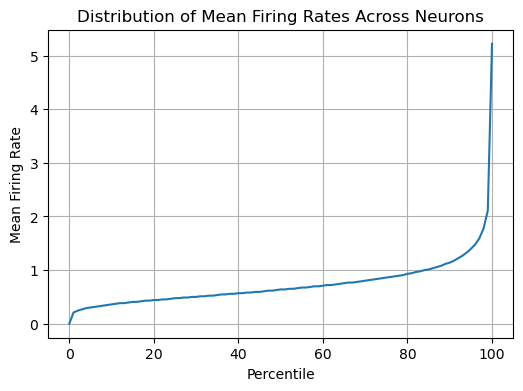

In [8]:
bins.drop(columns='bin').mean(axis=1).describe()

# plot the percentile of values of mean firing rates across neurons at each time bin
mean_rates = bins.drop(columns='bin').mean(axis=1)

# Calculate percentiles from 0 to 100
percentiles = np.arange(0, 101, 1)
percentile_values = np.percentile(mean_rates, percentiles)

# Create plot
plt.figure(figsize=(6, 4))
plt.plot(percentiles, percentile_values)
plt.xlabel('Percentile')
plt.ylabel('Mean Firing Rate')
plt.title('Distribution of Mean Firing Rates Across Neurons')
plt.grid(True)
plt.show()


# !! more columns

In [9]:
# how about target_rel_x, target_rel_y?

# Get data for modeling

### get x_var and y_car

In [10]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

dec.x_var = binned_spikes_sub.drop(columns=['bin']).reset_index(drop=True)
dec.y_var0 = dec.pursuit_data.drop(columns="point_index").reset_index(drop=True)
# Convert bool columns to int
bool_columns = dec.y_var0.select_dtypes(include=['bool']).columns
dec.y_var0[bool_columns] = dec.y_var0[bool_columns].astype(int)


### VIF

In [11]:
vif0 = reduce_multicollinearity.get_vif_df(dec.y_var0)
vif0.head(8)

0 out of 54 features are processed for VIF.
10 out of 54 features are processed for VIF.
20 out of 54 features are processed for VIF.
30 out of 54 features are processed for VIF.
40 out of 54 features are processed for VIF.
50 out of 54 features are processed for VIF.


,feature,vif
43,time,4793712724.60000
0,bin,4792496083.80000
51,target_index,639.90000
46,cum_distance,422.10000
15,gaze_mky_view_angle_l,234.00000
9,LDy,229.90000
53,target_y,146.40000
45,monkey_y,141.00000


### Correlations between features

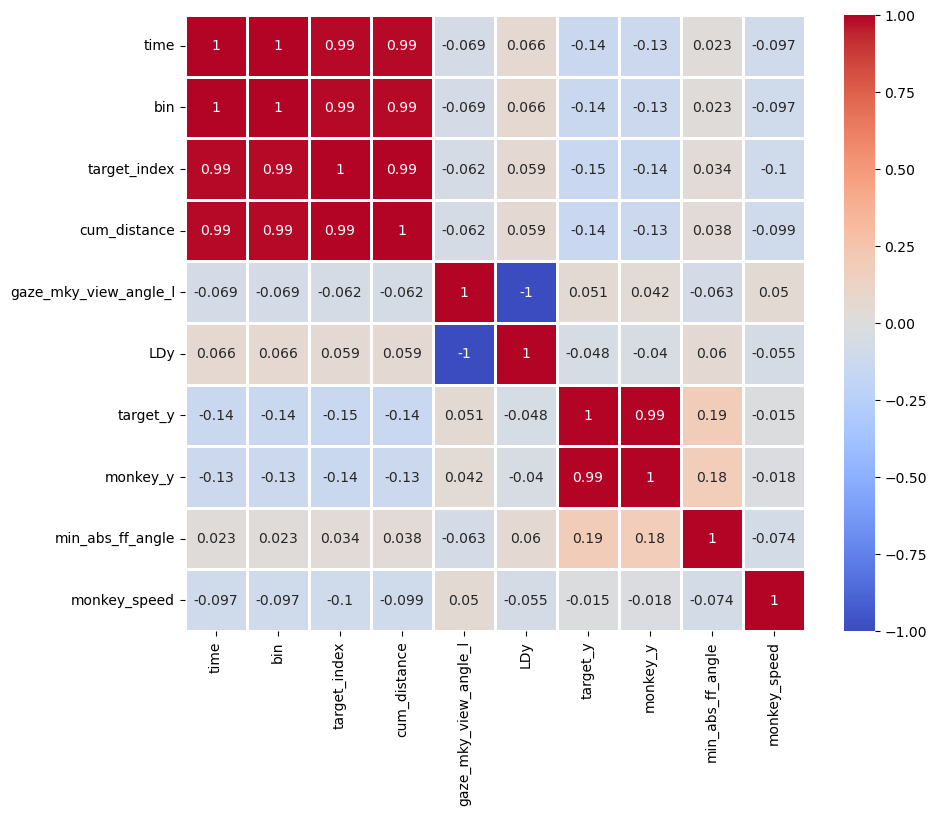

In [13]:
# calculate the correlation coefficient among the columns with VIF > 5
# specific_columns = vif_df[vif_df['vif'] > 5].feature.values
specific_columns = vif0.feature.values[:10]
corr_coeff = dec.y_var0[specific_columns].corr()
#plt.figure(figsize = (6, 6))
plt.figure(figsize = (10, 8))
sns.heatmap(corr_coeff, cmap='coolwarm', annot=True, linewidths=1, vmin=-1)
plt.show()

## drop columns and try again

In [14]:
columns_to_drop = ['time', 'cum_distance', 'target_index']

In [15]:
dec.y_var = dec.y_var0.drop(columns=columns_to_drop)

vif_df = reduce_multicollinearity.get_vif_df(dec.y_var)
vif_df.head(8)

0 out of 51 features are processed for VIF.
10 out of 51 features are processed for VIF.
20 out of 51 features are processed for VIF.
30 out of 51 features are processed for VIF.
40 out of 51 features are processed for VIF.
50 out of 51 features are processed for VIF.


,feature,vif
15,gaze_mky_view_angle_l,232.30000
9,LDy,228.60000
50,target_y,145.40000
44,monkey_y,139.80000
1,monkey_speed,92.60000
25,min_abs_ff_angle,90.60000
49,target_x,89.80000
26,min_abs_ff_angle_boundary,85.60000


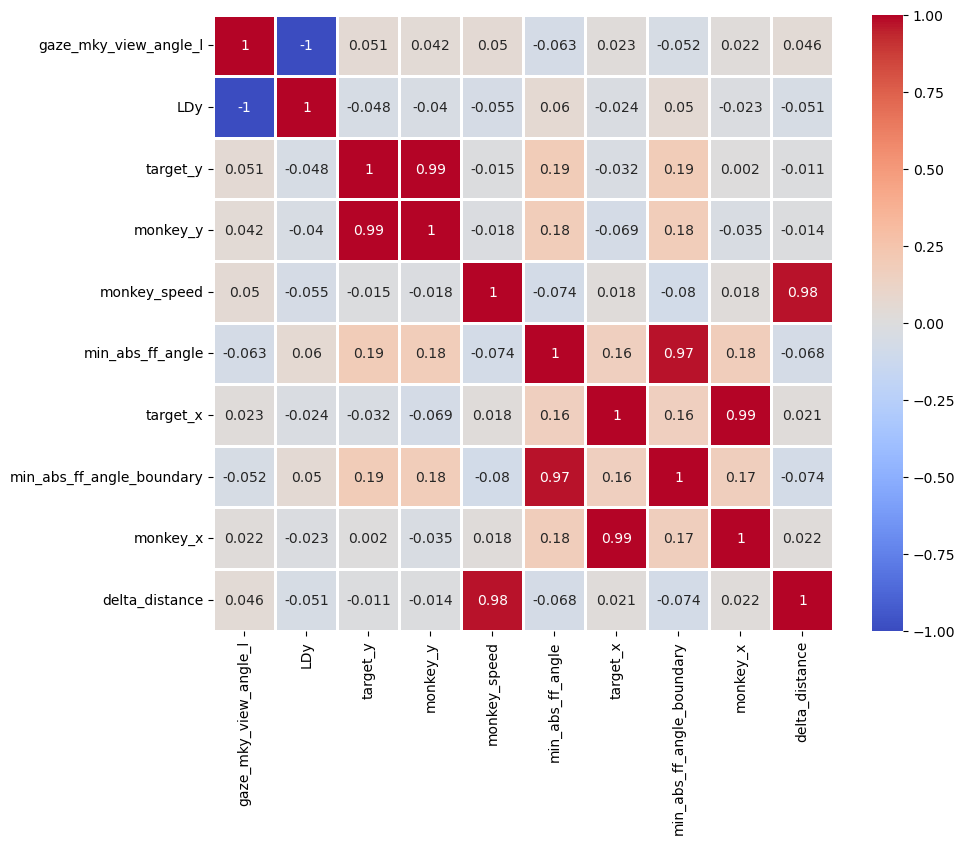

In [16]:
# calculate the correlation coefficient among the columns with VIF > 5
# specific_columns = vif_df[vif_df['vif'] > 5].feature.values
specific_columns = vif_df.feature.values[:10]
corr_coeff = dec.y_var[specific_columns].corr()
#plt.figure(figsize = (6, 6))
plt.figure(figsize = (10, 8))
sns.heatmap(corr_coeff, cmap='coolwarm', annot=True, linewidths=1, vmin=-1)
plt.show()

## Drop columns in behavioral data

In [17]:
print('dec.x_var.shape:', dec.x_var.shape)
print('dec.y_var.shape:', dec.y_var.shape)

dec.x_var.shape: (2248, 86)
dec.y_var.shape: (2248, 51)


## regression

In [ ]:
# # conduct linear regression on X and y
# plt.rcParams["figure.figsize"] = (20, 10)
# bins_to_plot = range(dec.y_var.bin.max())
# for i, column in enumerate(dec.y_var.columns):
#     plot_neural_data.plot_regression(dec.y_var, column, dec.x_var, bins_to_plot=None, min_r_squared_to_plot=0.3)
#     # if i == 3:
#     #     break

# lags

In [19]:
dec._get_y_var_lags(max_lag_number=5, continuous_data=dec.behav_data.drop(columns=['point_index'] +columns_to_drop))
# check whether there's column with NA
sum_na = dec.y_var_lags.isna().sum()
sum_na[sum_na > 0]
dec.y_var_lags_all = dec.y_var_lags.copy()
dec.y_var_lags = dec.y_var_lags_all[dec.y_var_lags_all['bin_0'].isin(dec.y_var['bin'])].reset_index(drop=True)

In [20]:
dec.y_var_lags

,bin_0,monkey_speed_0,monkey_angle_0,monkey_dw_0,monkey_ddw_0,monkey_ddv_0,monkey_speeddummy_0,whether_new_distinct_stop_0,delta_distance_0,LDy_0,LDz_0,RDy_0,RDz_0,gaze_mky_view_x_l_0,gaze_mky_view_y_l_0,gaze_mky_view_angle_l_0,gaze_mky_view_x_r_0,gaze_mky_view_y_r_0,gaze_mky_view_angle_r_0,eye_world_speed_0,valid_view_point_l_0,valid_view_point_r_0,num_alive_ff_0,num_visible_ff_0,min_ff_distance_0,min_abs_ff_angle_0,min_abs_ff_angle_boundary_0,min_visible_ff_distance_0,min_abs_visible_ff_angle_0,min_abs_visible_ff_angle_boundary_0,catching_ff_0,any_ff_visible_0,target_distance_0,target_angle_0,target_angle_to_boundary_0,target_last_seen_time_0,target_last_seen_distance_frozen_0,target_last_seen_angle_frozen_0,target_last_seen_angle_to_boundary_frozen_0,target_visible_dummy_0,time_since_last_capture_0,traj_curv_0,target_opt_arc_dheading_0,monkey_x_0,monkey_y_0,gaze_world_x_l_0,gaze_world_y_l_0,gaze_world_x_r_0,gaze_world_y_r_0,target_x_0,...,monkey_speed_5,monkey_angle_5,monkey_dw_5,monkey_ddw_5,monkey_ddv_5,monkey_speeddummy_5,whether_new_distinct_stop_5,delta_distance_5,LDy_5,LDz_5,RDy_5,RDz_5,gaze_mky_view_x_l_5,gaze_mky_view_y_l_5,gaze_mky_view_angle_l_5,gaze_mky_view_x_r_5,gaze_mky_view_y_r_5,gaze_mky_view_angle_r_5,eye_world_speed_5,valid_view_point_l_5,valid_view_point_r_5,num_alive_ff_5,num_visible_ff_5,min_ff_distance_5,min_abs_ff_angle_5,min_abs_ff_angle_boundary_5,min_visible_ff_distance_5,min_abs_visible_ff_angle_5,min_abs_visible_ff_angle_boundary_5,catching_ff_5,any_ff_visible_5,target_distance_5,target_angle_5,target_angle_to_boundary_5,target_last_seen_time_5,target_last_seen_distance_frozen_5,target_last_seen_angle_frozen_5,target_last_seen_angle_to_boundary_frozen_5,target_visible_dummy_5,time_since_last_capture_5,traj_curv_5,target_opt_arc_dheading_5,monkey_x_5,monkey_y_5,gaze_world_x_l_5,gaze_world_y_l_5,gaze_world_x_r_5,gaze_world_y_r_5,target_x_5,target_y_5
0,156.00000,41.00465,1.33400,0.00011,-0.00402,-13.40594,1.00000,0.00000,0.68236,1.37732,-1.81714,-2.68481,-3.29260,6.08015,315.11081,-0.01929,-6.65558,173.63062,0.03831,1475.93381,1.00000,1.00000,15.00000,1.00000,30.88639,-2.90449,-2.88646,297.51210,-0.24793,-0.21432,0.00000,1.00000,153.47828,0.09523,0.03003,100.00000,400.00000,0.00000,0.00000,0.00000,15.73202,0.00021,0.03154,155.21442,321.85620,235.04676,626.74730,189.47658,492.20289,176.86879,...,189.15054,1.42592,0.00021,0.00007,-47.66480,1.00000,0.00000,3.13101,-0.93835,-2.37958,-4.07336,-0.72974,-5.44432,240.61052,0.02262,-54.27417,783.13124,0.06919,829.62340,1.00000,0.00000,17.00000,2.00000,55.95329,-2.96595,-2.94511,55.95329,0.40858,0.23762,0.00000,1.00000,236.24983,-0.01153,-0.00000,100.00000,400.00000,0.00000,0.00000,0.00000,15.23391,-0.00043,-0.10122,140.06869,240.43309,169.41909,479.30882,199.42619,1023.19545,176.86879,473.79919
1,157.00000,0.00000,1.32465,-0.52076,0.01692,0.00000,0.00000,0.00000,0.00000,4.44922,-6.71094,0.35718,-8.49951,5.13831,84.72627,-0.06057,1.92178,66.91413,-0.02871,36.76910,1.00000,1.00000,15.00000,1.00000,30.90155,-2.89537,-2.87734,297.57850,-0.23879,-0.20518,0.00000,1.00000,153.45376,0.10460,0.03938,100.00000,400.00000,0.00000,0.00000,0.00000,15.83158,0.00021,0.03151,155.22058,321.88010,180.84873,402.80068,173.38897,386.30916,176.86879,...,187.14564,1.41381,-0.20728,-0.00932,-0.84561,1.00000,0.00000,3.11111,-0.57520,-0.83142,-3.89819,-1.28638,-8.41835,689.04775,0.01222,-28.78283,444.29861,0.06469,5811.97805,1.00000,1.00000,17.00000,3.00000,40.01443,-2.95904,-2.93871,40.01443,0.08061,0.03513,0.00000,1.00000,217.58567,-0.00008,-0.00000,100.00000,400.00000,0.00000,0.00000,0.00000,15.33357,-0.00076,-0.13750,142.83354,258.89194,242.24522,940.78269,183.86680,702.22700,176.86879,473.79919
2,158.00000,0.00000,1.32482,0.00000,0.00265,0.00000,0.00000,0.00000,0.00000,4.51331,-6.14270,0.48108,-7.91968,5.85391,92.62547,-0.06312,2.10938,71.88218,-0.02934,139.61149,1.00000,1.00000,14.00000,1.00000,30.90155,-2.90198,-2.88404,294.94761,-0.24635,-0.21244,0.00000,1.00000,153.45376,0.1

In [80]:
corr_threshold_for_lags_of_a_feature = 0.85
dec.y_var_lags_reduced = reduce_multicollinearity.drop_feature_lags_with_high_corr(dec.y_var, dec.y_var_lags, lag_numbers=dec.lag_numbers, 
                                                                                        corr_threshold_for_lags=corr_threshold_for_lags_of_a_feature, verbose=True)
dec.y_var_lags_reduced


====================Dropping lags of features with high correlation for each feature====================
Processing feature 1/51
34 columns of bin dropped: ['bin_0', 'bin_0', 'bin_0', 'bin_0', 'bin_-1', 'bin_-1', 'bin_-1', 'bin_-1', 'bin_1', 'bin_1', 'bin_1', 'bin_1', 'bin_-2', 'bin_-2', 'bin_-2', 'bin_-2', 'bin_-2', 'bin_-2', 'bin_-2', 'bin_2', 'bin_2', 'bin_2', 'bin_-3', 'bin_-3', 'bin_-3', 'bin_-3', 'bin_-3', 'bin_3', 'bin_3', 'bin_-4', 'bin_-4', 'bin_-4', 'bin_4', 'bin_-5']
55 columns of monkey_angle dropped: ['monkey_angle_0', 'monkey_angle_0', 'monkey_angle_0', 'monkey_angle_0', 'monkey_angle_0', 'monkey_angle_0', 'monkey_angle_0', 'monkey_angle_0', 'monkey_angle_0', 'monkey_angle_0', 'monkey_angle_-1', 'monkey_angle_-1', 'monkey_angle_-1', 'monkey_angle_-1', 'monkey_angle_-1', 'monkey_angle_-1', 'monkey_angle_-1', 'monkey_angle_-1', 'monkey_angle_-1', 'monkey_angle_1', 'monkey_angle_1', 'monkey_angle_1', 'monkey_angle_1', 'monkey_angle_1', 'monkey_angle_1', 'monkey_angle_1', 'm

In [84]:

corr_threshold = 0.85
# _, columns_dropped = reduce_multicollinearity.filter_specific_subset_of_y_var_lags_by_corr(
#         dec.y_var_lags_reduced, corr_threshold=corr_threshold_for_lags, verbose=True)
corr_df = reduce_multicollinearity.get_ranked_correlations(dec.y_var_lags_reduced)

corr_df


Found 64980 pairs of variables with correlations:

Top 10 highest correlations:
                                   var1                                  var2  correlation  abs_correlation
0    target_last_seen_distance_frozen_4    target_last_seen_distance_frozen_5      0.84989          0.84989
1                        target_angle_4            target_angle_to_boundary_4      0.84907          0.84907
2                    min_ff_distance_-4                    min_ff_distance_-5      0.84735          0.84735
3                                 LDz_0               gaze_mky_view_angle_l_0      0.84633          0.84633
4                       num_alive_ff_-5                        num_alive_ff_5      0.84587          0.84587
5              gaze_mky_view_angle_l_-5              gaze_mky_view_angle_r_-5      0.83986          0.83986
6  min_abs_visible_ff_angle_boundary_-4  min_abs_visible_ff_angle_boundary_-5      0.83675          0.83675
7                                LDz_-2              ga

,var1,var2,correlation,abs_correlation
0,target_last_seen_distance_frozen_4,target_last_seen_distance_frozen_5,0.84989,0.84989
1,target_angle_4,target_angle_to_boundary_4,0.84907,0.84907
2,min_ff_distance_-4,min_ff_distance_-5,0.84735,0.84735
3,LDz_0,gaze_mky_view_angle_l_0,0.84633,0.84633
4,num_alive_ff_-5,num_alive_ff_5,0.84587,0.84587
...,...,...,...,...
64975,gaze_world_x_r_-5,traj_curv_5,0.00000,0.00000
64976,valid_view_point_r_-2,target_angle_to_boundary_5,0.00000,0.00000
64977,monkey_dw_3,gaze_world_x_l_3,0.00000,0.00000
64978,monkey_ddv_2,catching_ff_3,-0.00000,0.00000


In [ ]:

high_corr_pair_df = reduce_multicollinearity.get_pairs_of_high_corr_features(
            dec.y_var_lags_reduced, corr_threshold=corr_threshold)

In [386]:
# vif_lags = reduce_multicollinearity.get_vif_df(dec.y_var_lags_reduced, verbose=True)
# vif_lags.head(8)

0 out of 406 features are processed for VIF.


KeyboardInterrupt: 

# CCA

https://medium.com/@pozdrawiamzuzanna/canonical-correlation-analysis-simple-explanation-and-python-example-a5b8e97648d2

## No lagging

In [ ]:
cca_no_lag = cca_class.CCAclass(X1=data_item.x_var, X2=data_item.y_var_reduced, lagging_included=False)

In [ ]:
cca_no_lag.conduct_cca()

## with lags

In [242]:
# # dec.reduce_y_var_lags()

# ## or
# # dec.make_or_retrieve_y_var_lags_reduced()

# dec.y_var_lags = neural_data_processing.add_lags_to_each_feature(
#             dec.y_var, dec.lag_numbers)
# dec.y_var_lags['bin'] = dec.y_var_lags['bin_0']
# # drop all columns in dec.y_var_lags that has 'bin' but is not 'bin'
# bin_cols_to_drop = [col for col in dec.y_var_lags.columns if 'bin' in col and col != 'bin']
# dec.y_var_lags = dec.y_var_lags.drop(columns=bin_cols_to_drop)
# dec.y_var_lags

In [239]:
cca_lags = cca_class.CCAclass(X1=dec.x_var, X2=dec.y_var_lags_reduced, lagging_included=True)

AttributeError: 'DecodeTargetClass' object has no attribute 'y_var_lags_reduced'

In [ ]:
cca_lags.conduct_cca()

In [ ]:
gc.collect()

## compare lag vs no lag

In [ ]:
canon_df = pd.DataFrame(cca_no_lag.canon_corr, columns = ['no_lag'])
canon_df[f'lag_{data_item.max_lag_number}'] = cca_lags.canon_corr
canon_df['component'] = [f'CC {i+1}' for i in range(cca_lags.n_components)]
# convert canon_df to long format
canon_df_long = pd.melt(canon_df, id_vars=['component'], var_name='lag', value_name='canon_coeff')

In [ ]:
# make a sns bar plot on canon_df_long
plt.figure(figsize=(8, 6))
sns.barplot(x='component', y='canon_coeff', data=canon_df_long, hue='lag')
plt.show()

## cca_inst

In [ ]:
cca_inst = cca_lags

In [ ]:
cca_inst = cca_no_lag

## No lagging

In [221]:
cca_no_lag = cca_class.CCAclass(X1=dec.x_var, X2=dec.y_var, lagging_included=False)

Training CCA, kernel = None, regularization = 0.0000, 10 components
Canonical Correlation Per Component Pair: [0.55533 0.36923 0.26985 0.20758 0.19212 0.16008 0.15522 0.1277  0.11286
 0.1018 ]
% Shared Variance: [0.3084  0.13633 0.07282 0.04309 0.03691 0.02562 0.02409 0.01631 0.01274
 0.01036]


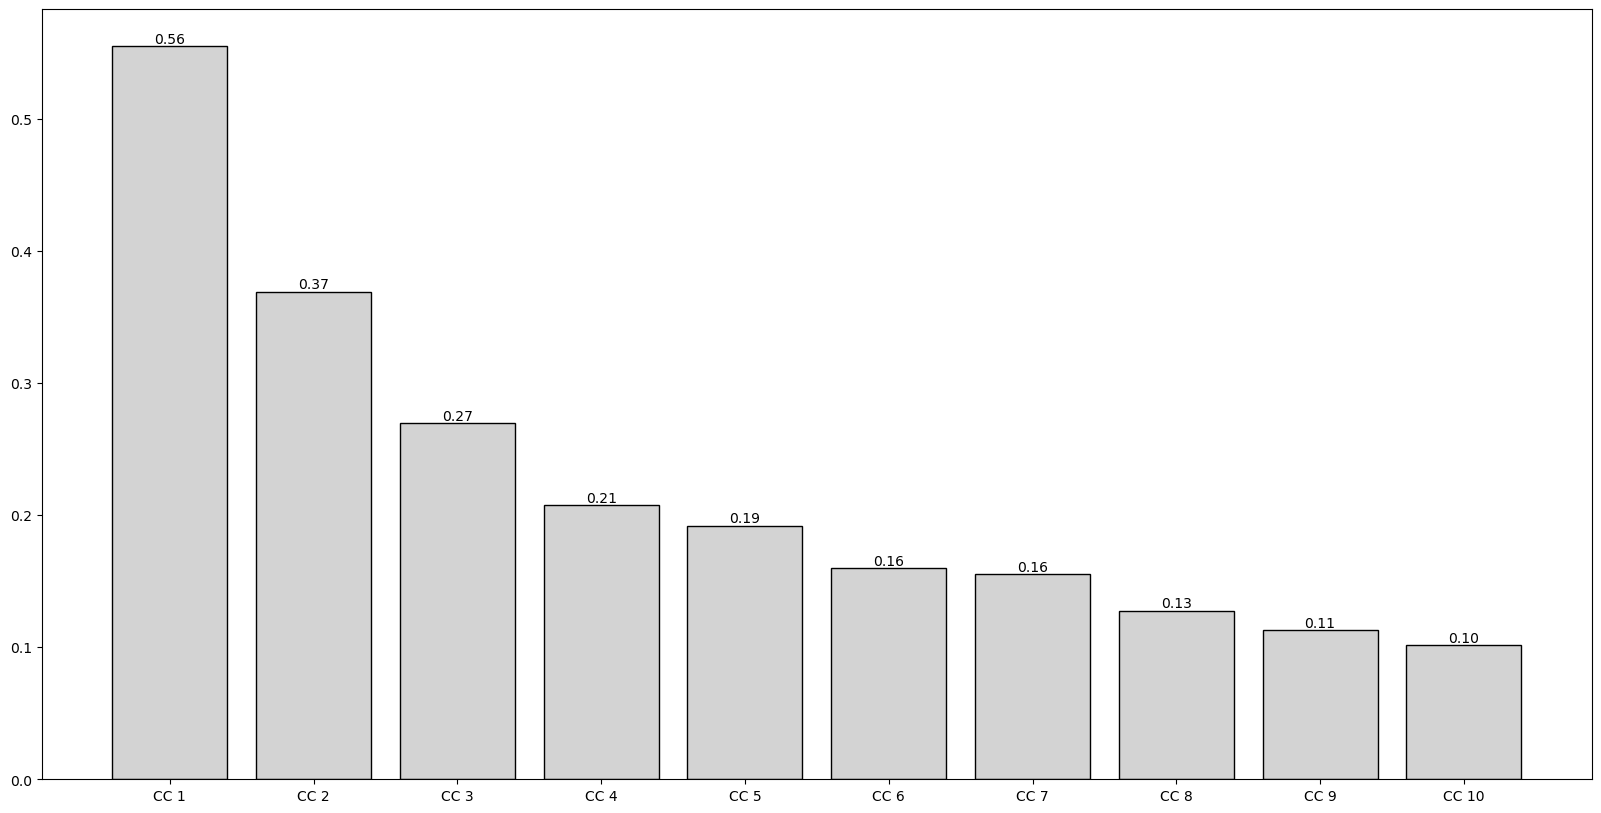

In [222]:
cca_no_lag.conduct_cca()
cca_inst = cca_no_lag

## loadings

### neurons

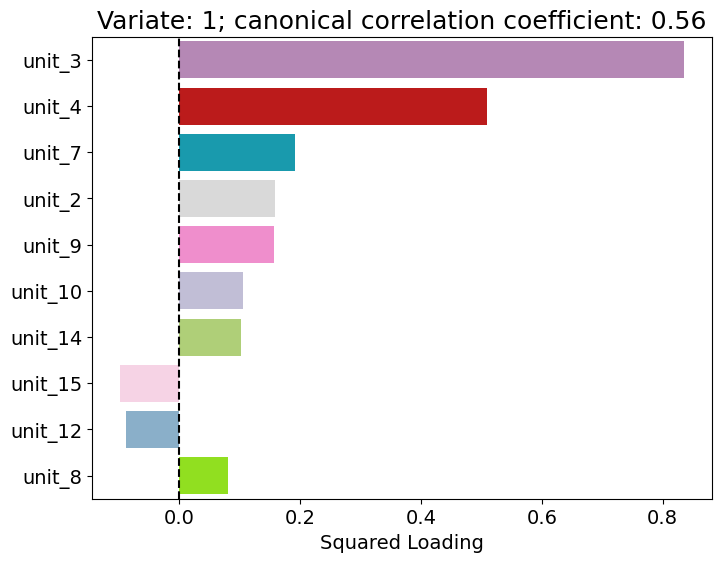

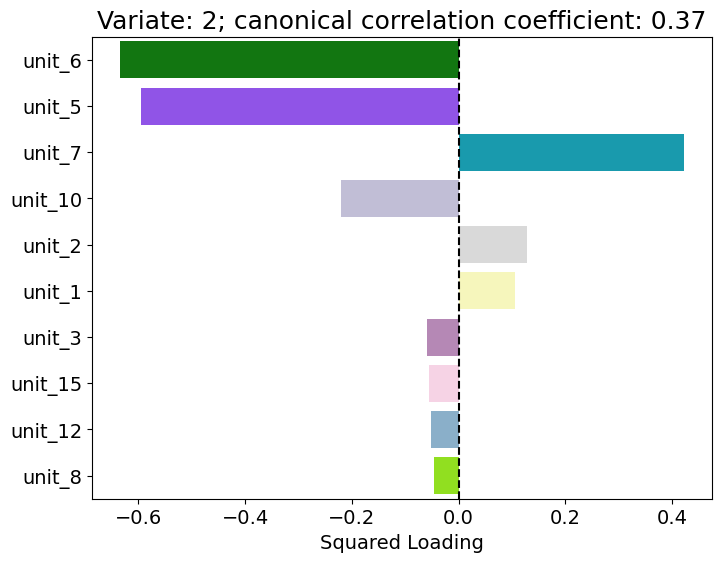

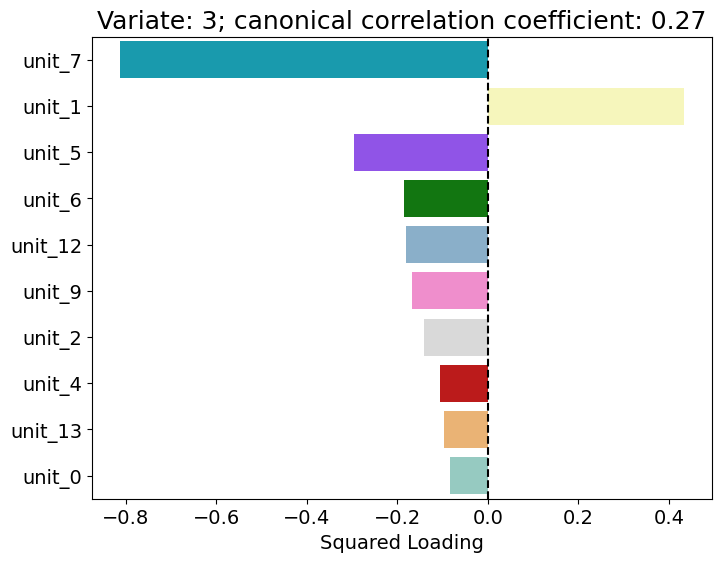

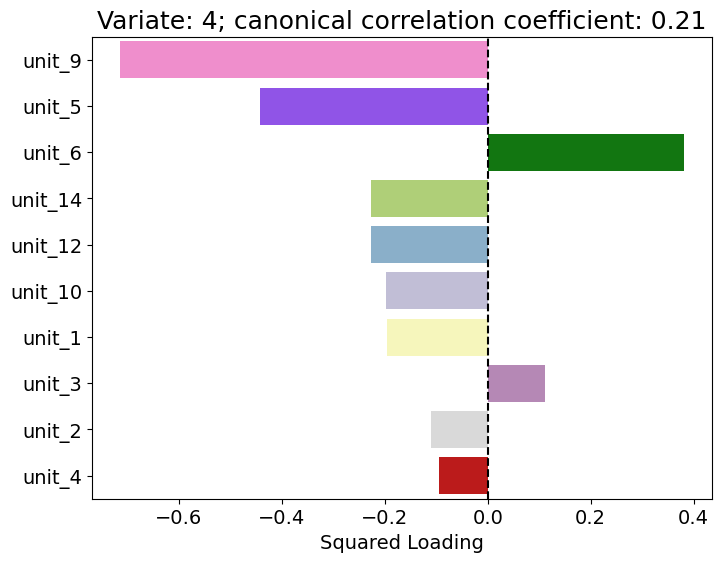

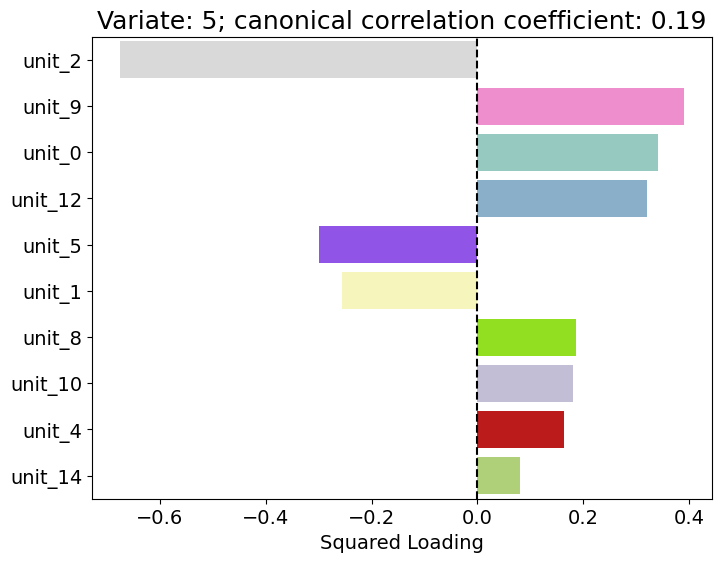

In [223]:
cca_inst.plot_ranked_loadings(X1_or_X2='X1', squared=False)

### behavior

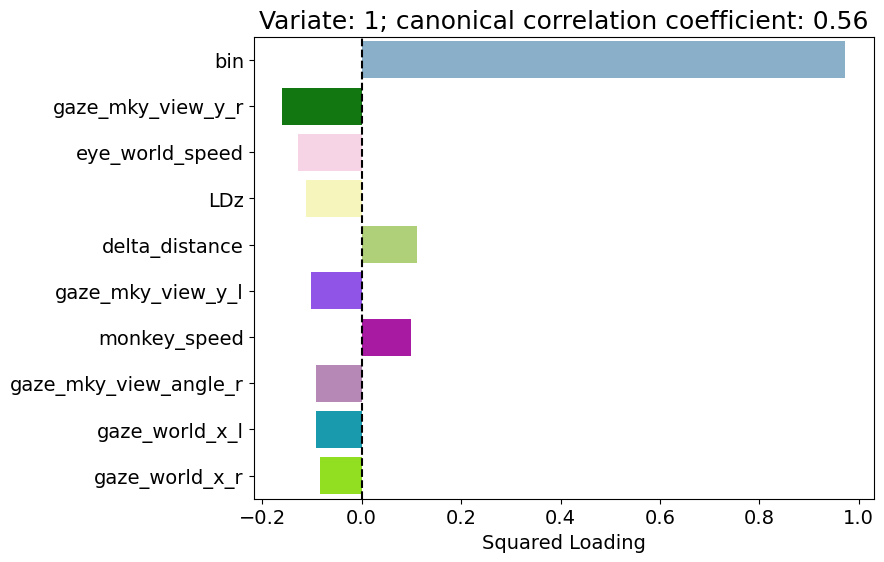

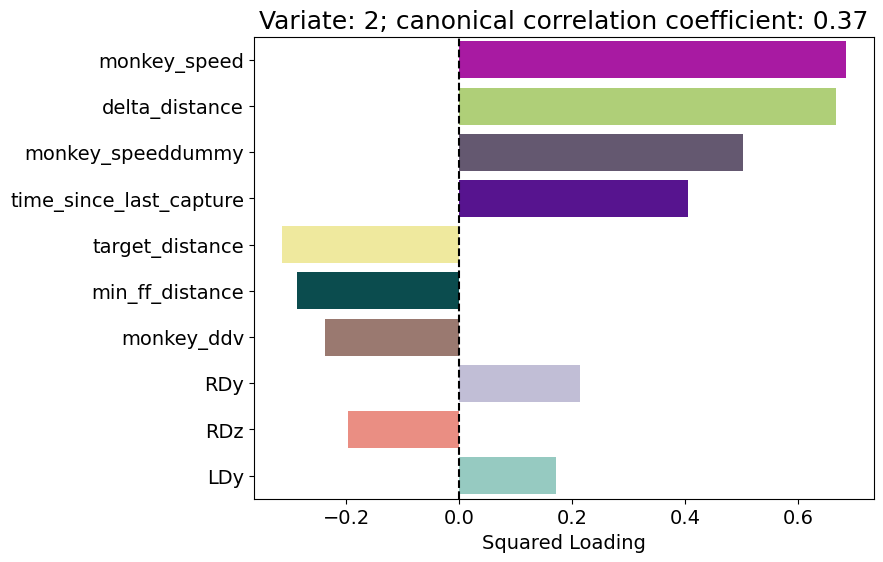

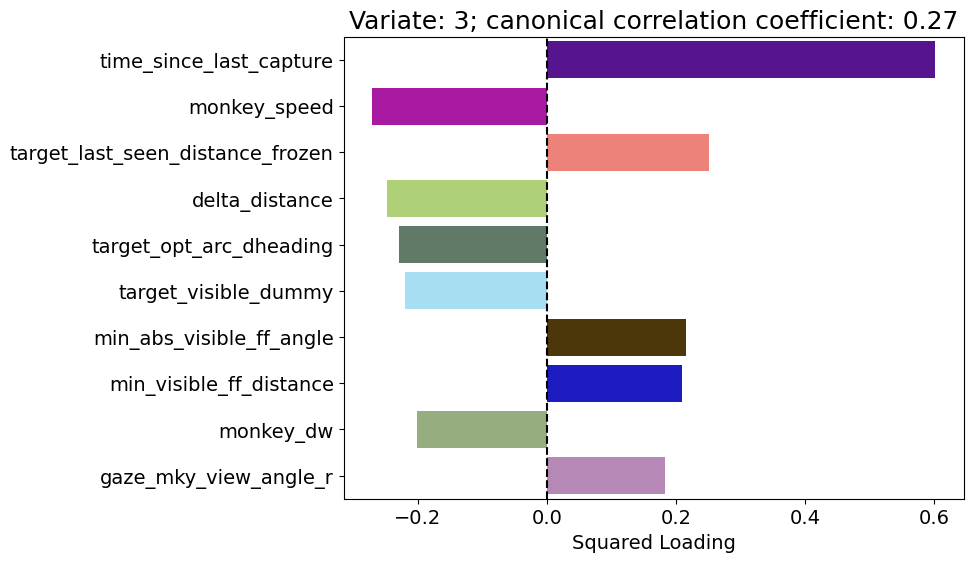

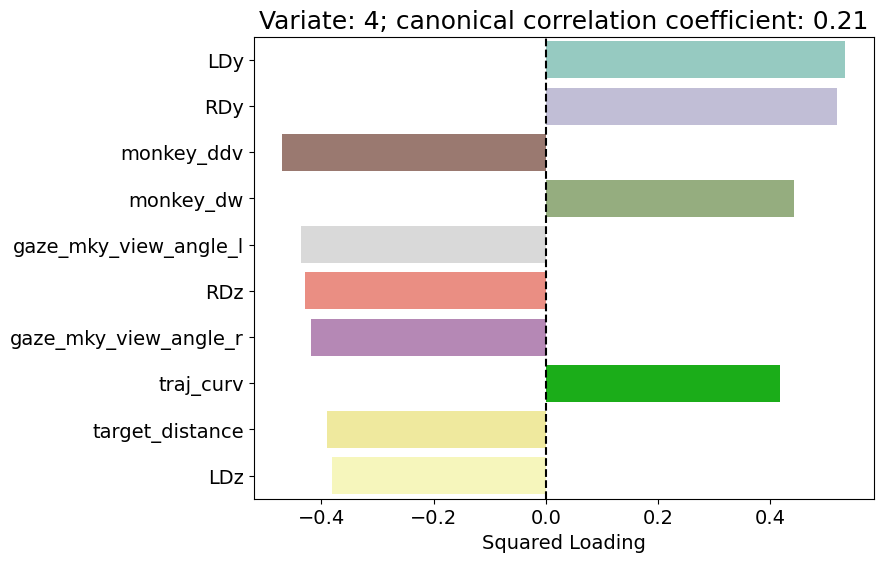

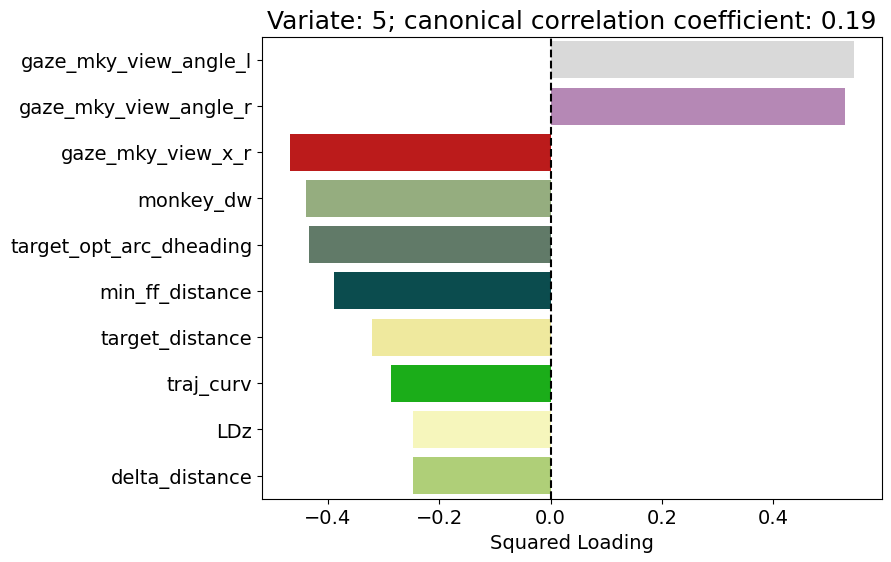

In [224]:
cca_inst.plot_ranked_loadings(X1_or_X2='X2', squared=False)

## squared loadings

### neurons

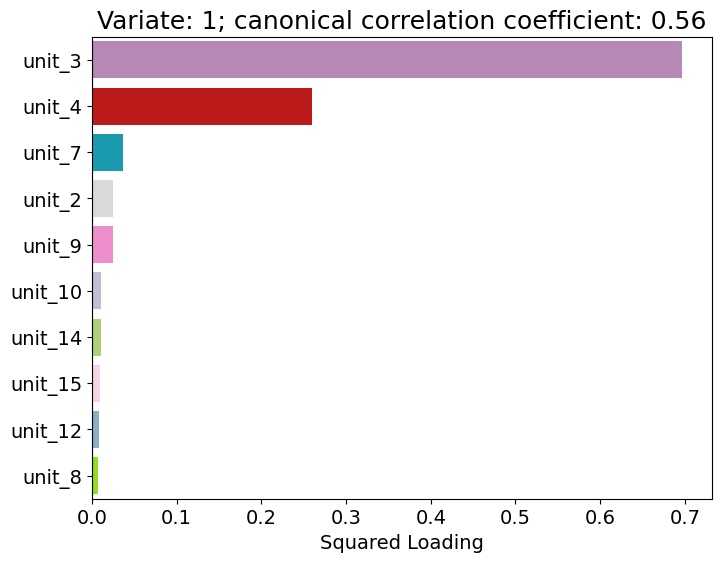

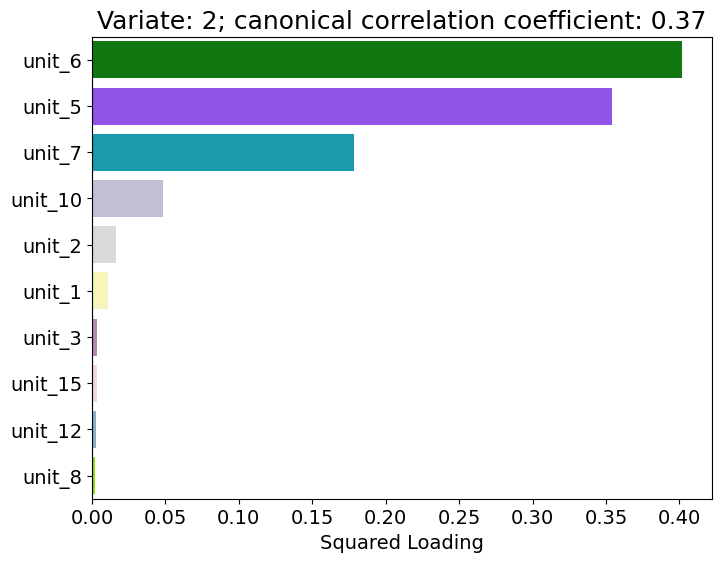

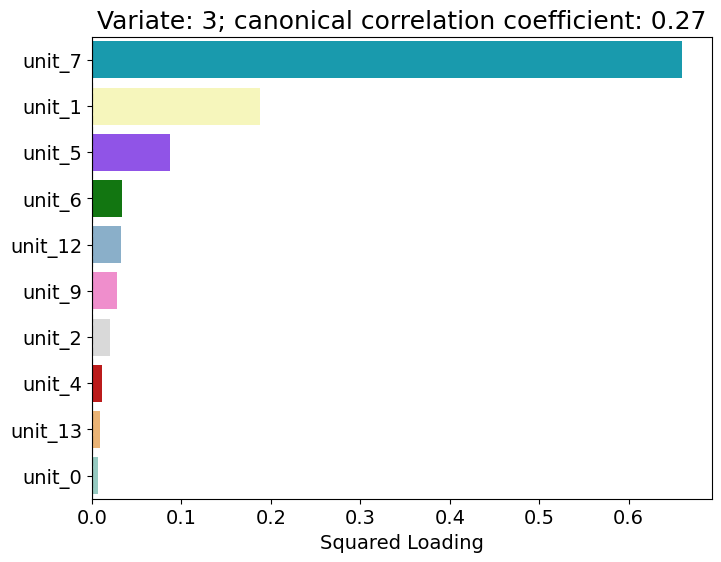

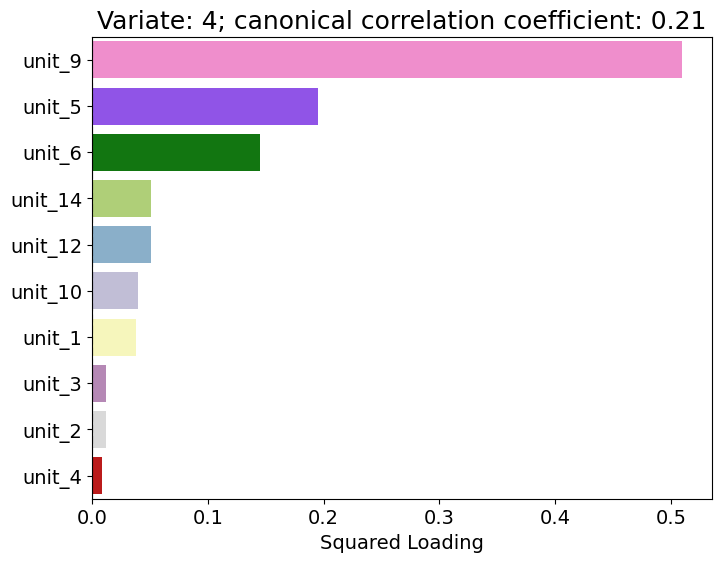

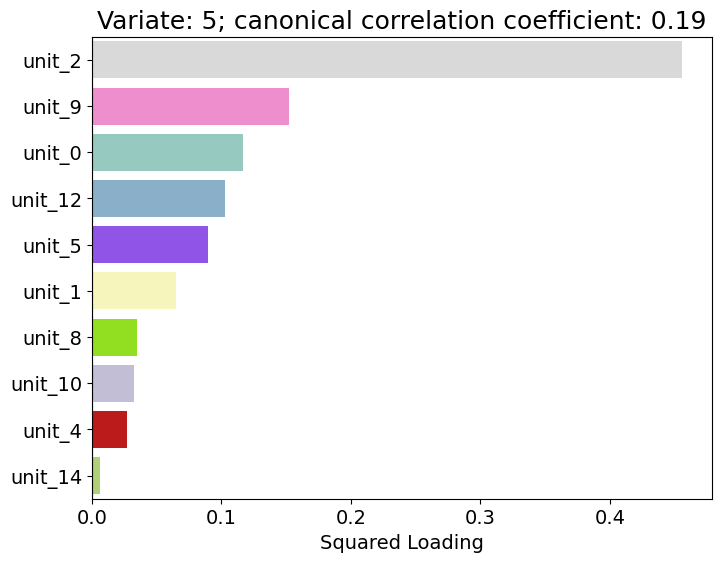

In [225]:
cca_inst.plot_ranked_loadings(X1_or_X2='X1')

### behavior

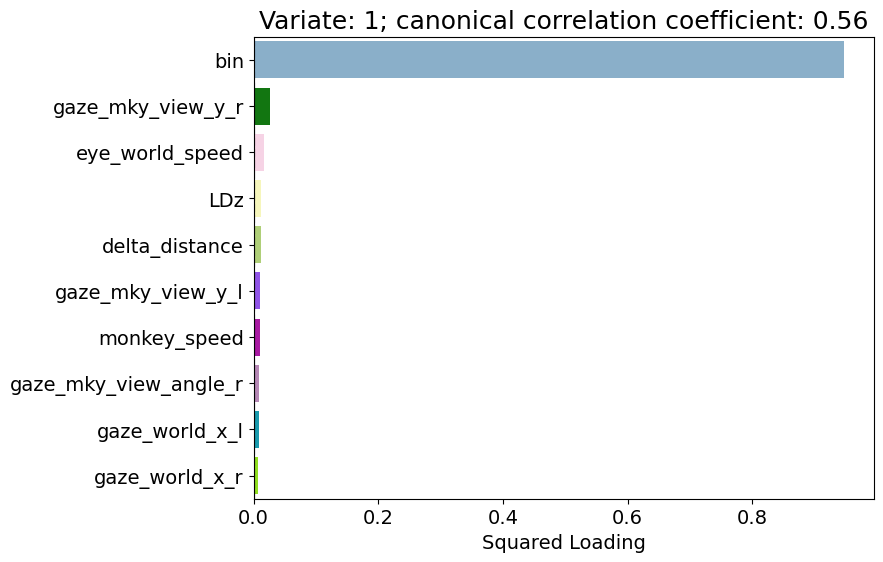

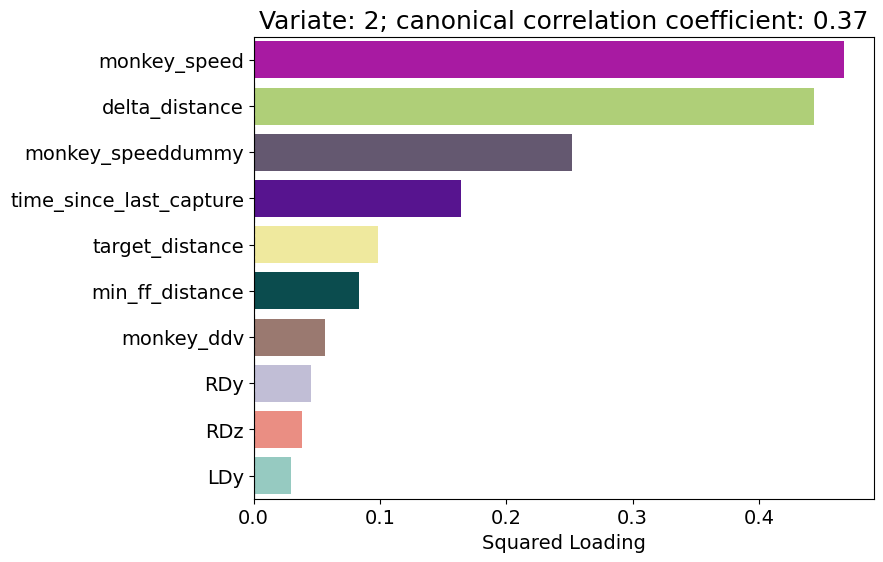

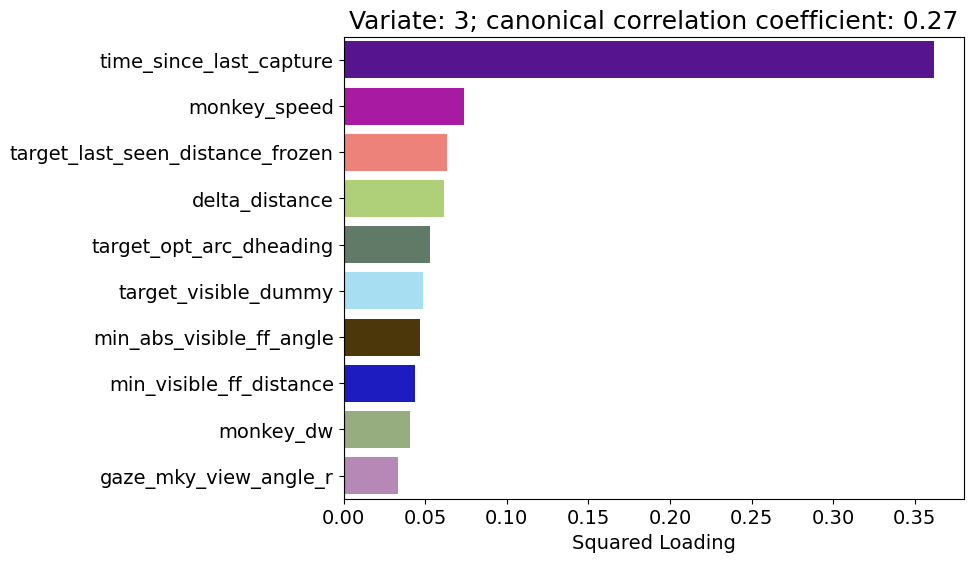

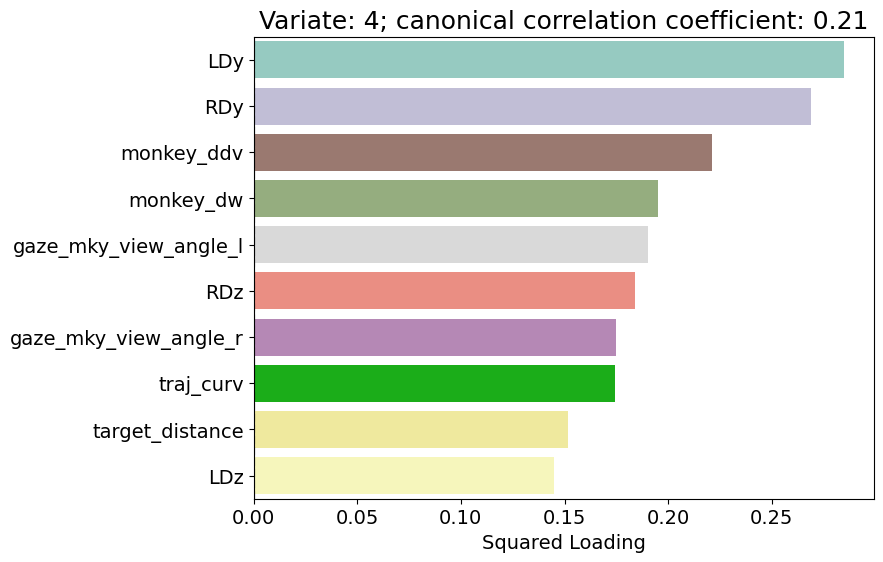

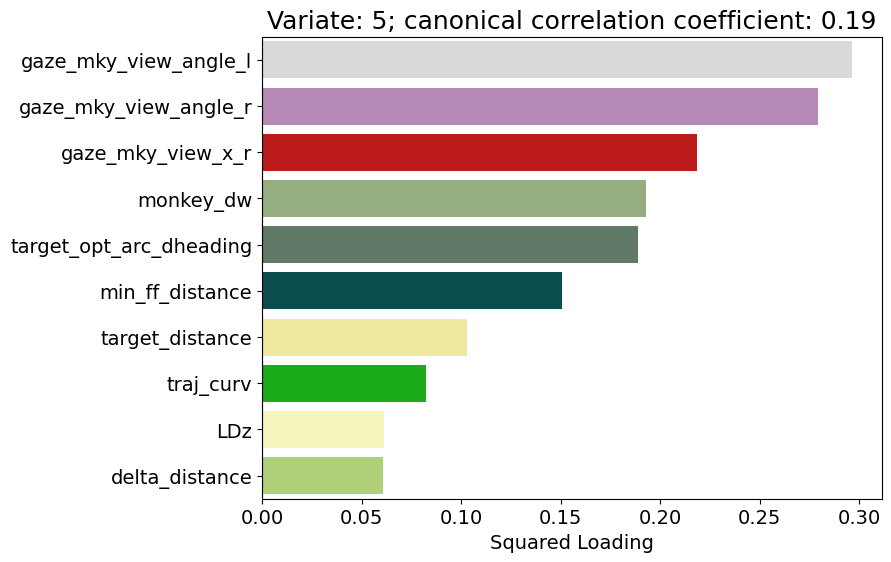

In [ ]:
cca_inst.plot_ranked_loadings(X1_or_X2='X2')

## abs weights ranked

### neurons

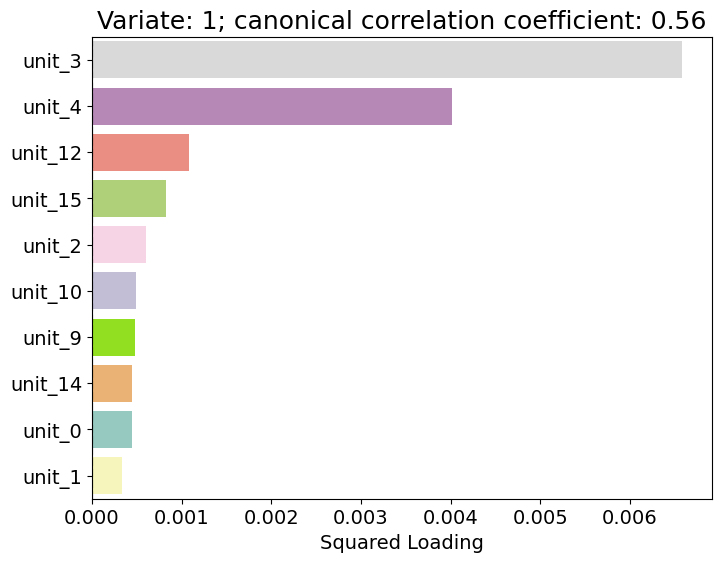

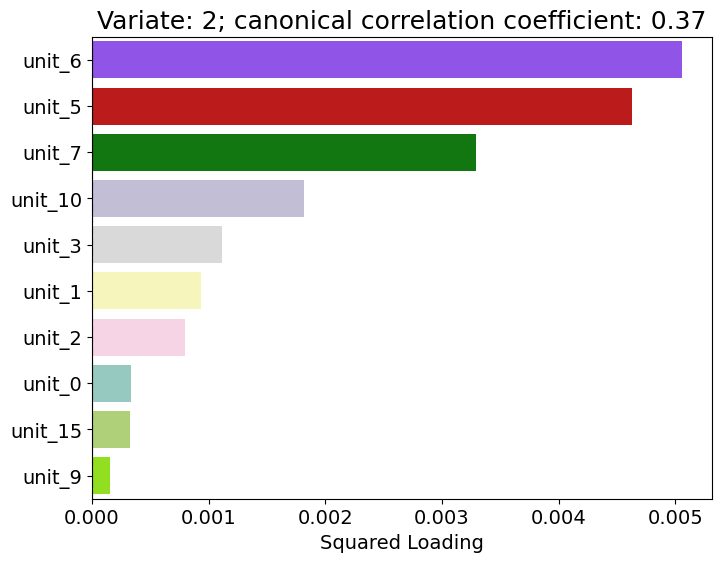

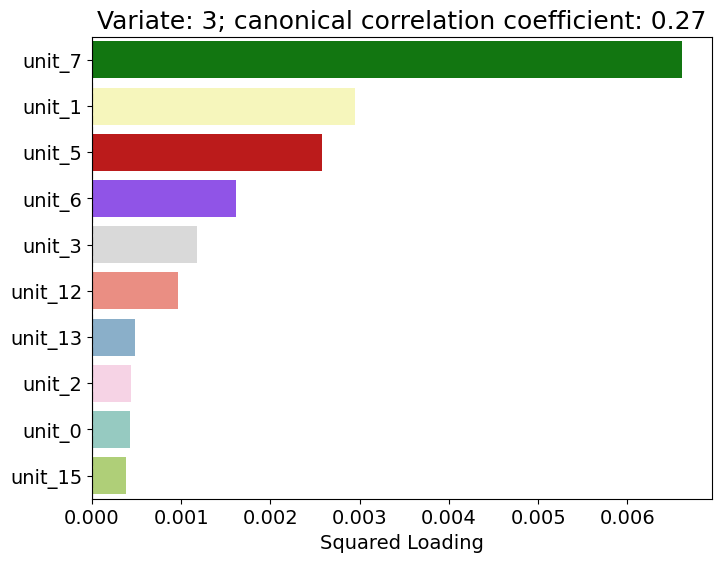

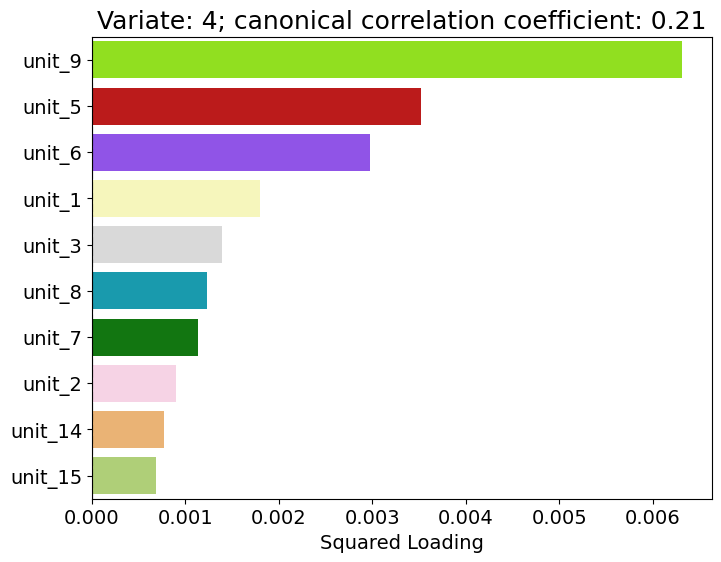

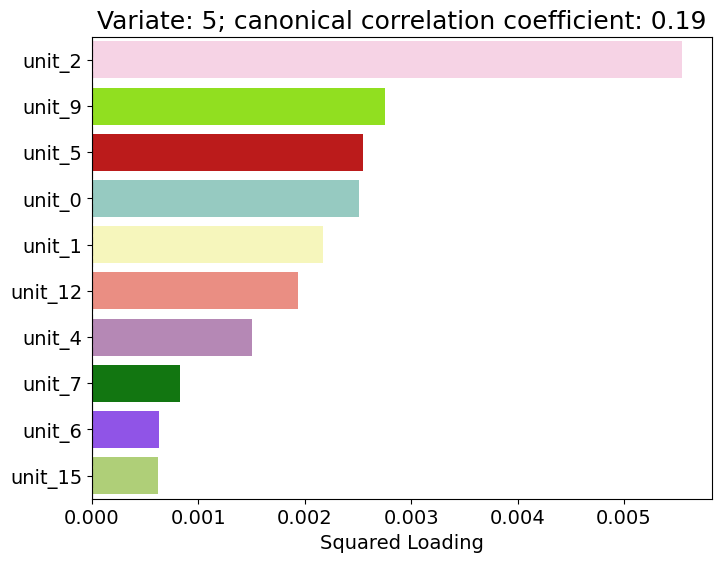

In [ ]:
cca_inst.plot_ranked_weights()

### behavior

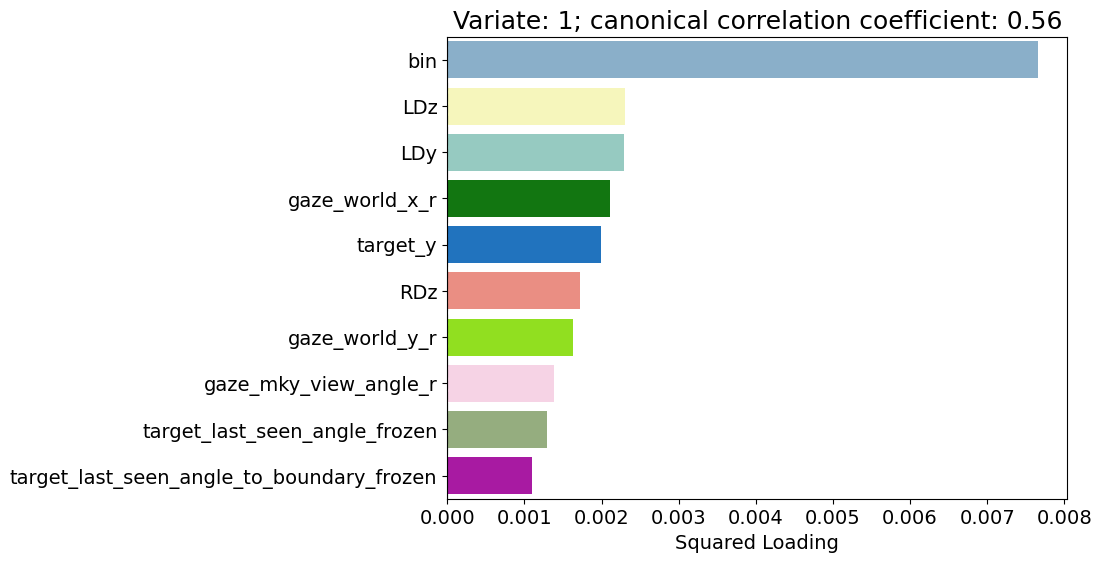

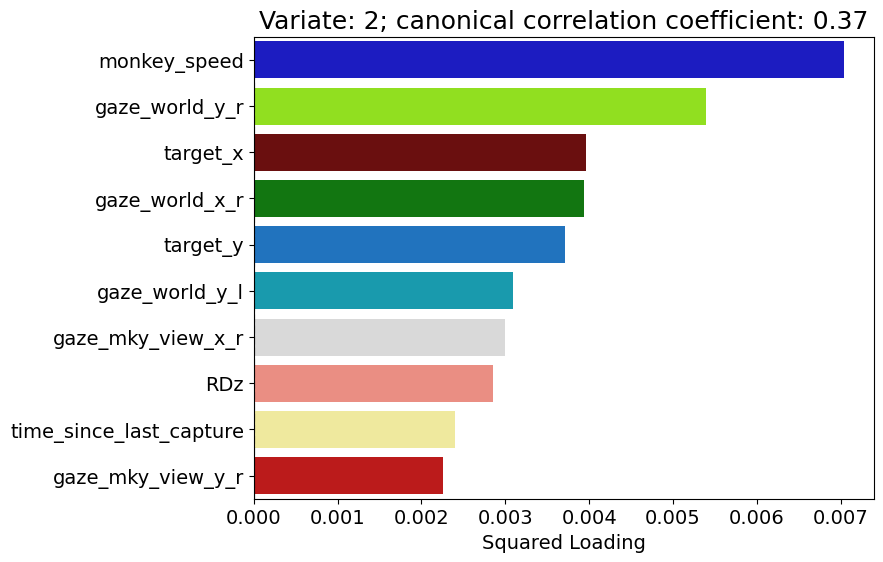

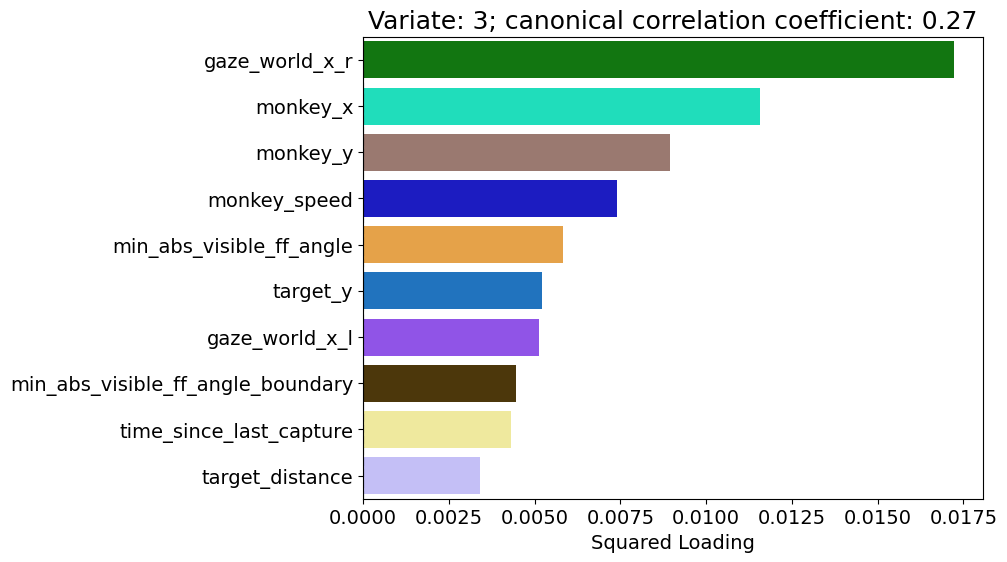

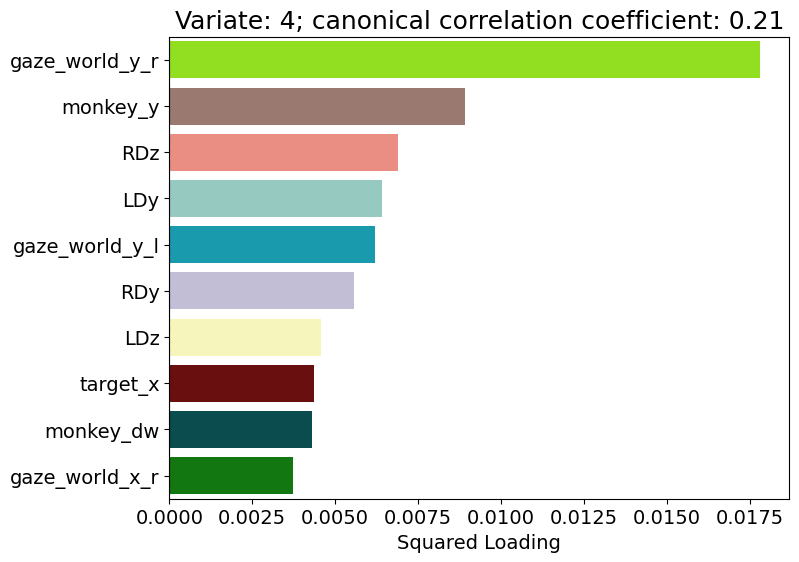

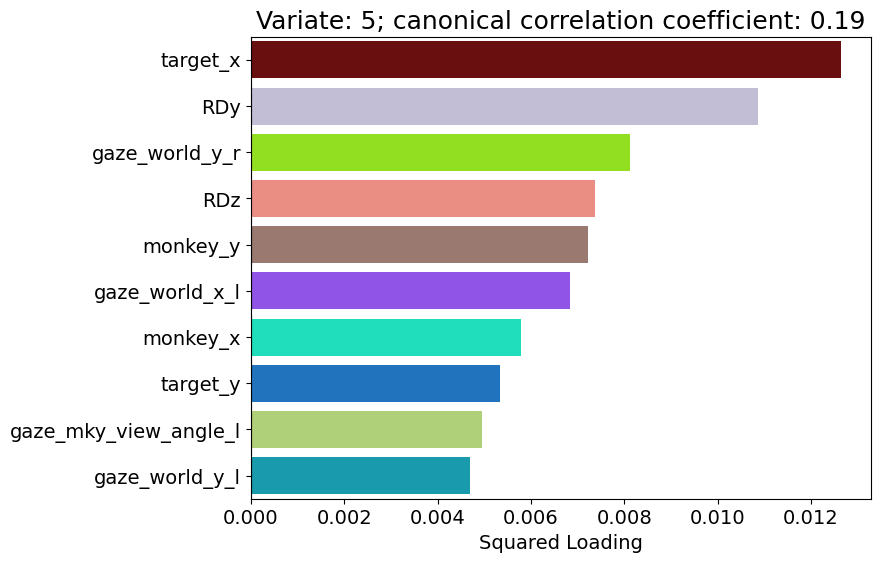

In [ ]:
cca_inst.plot_ranked_weights(X1_or_X2='X2')

## plot real weights

### neurons

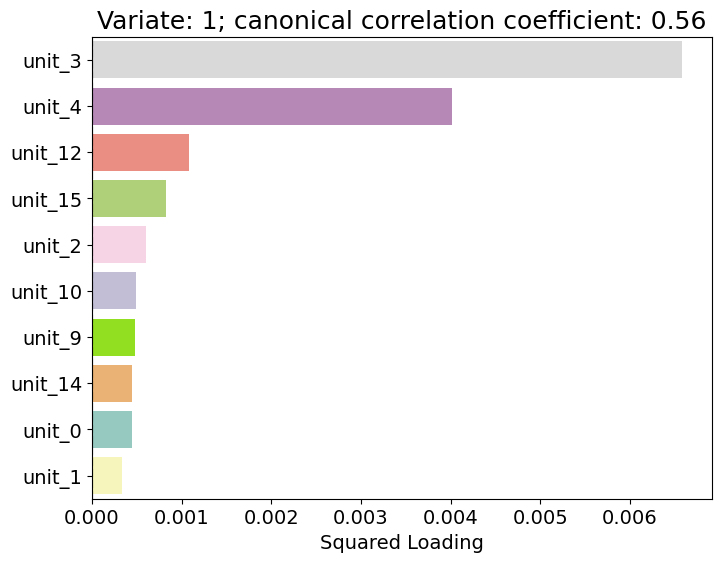

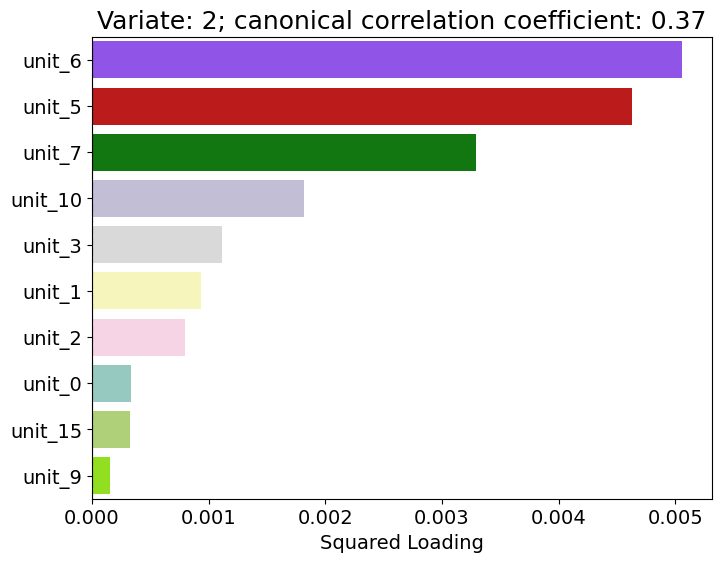

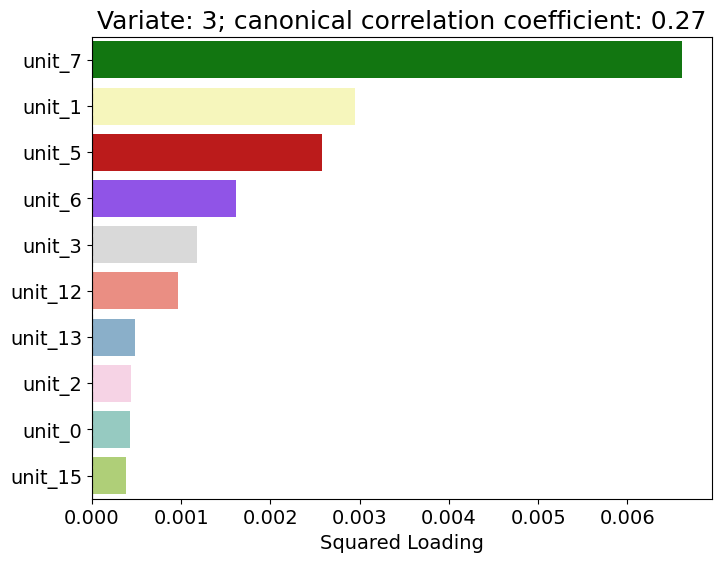

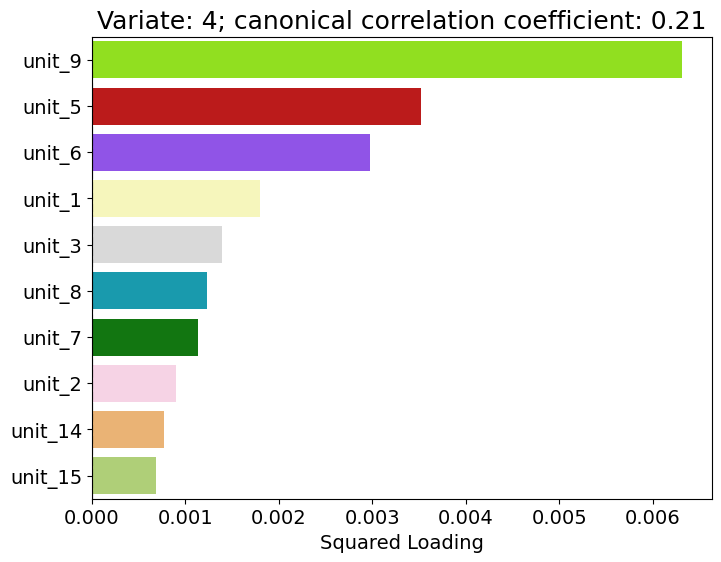

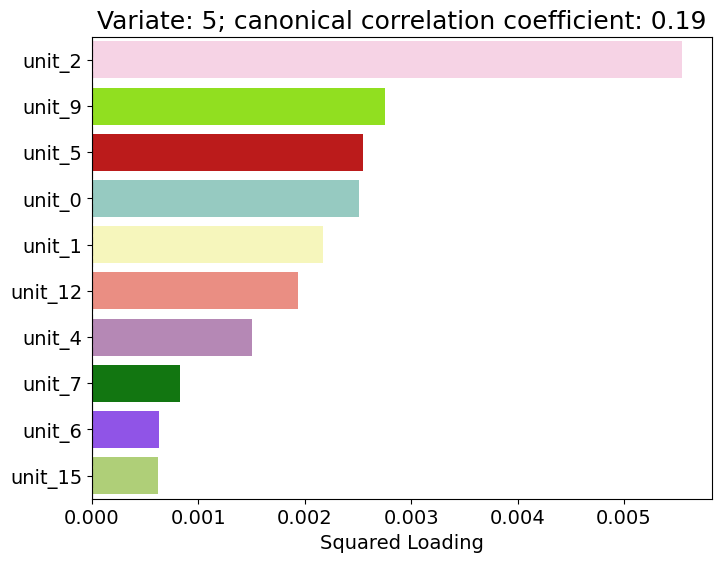

In [ ]:
cca_inst.plot_ranked_weights(abs_value=False)

### behavior

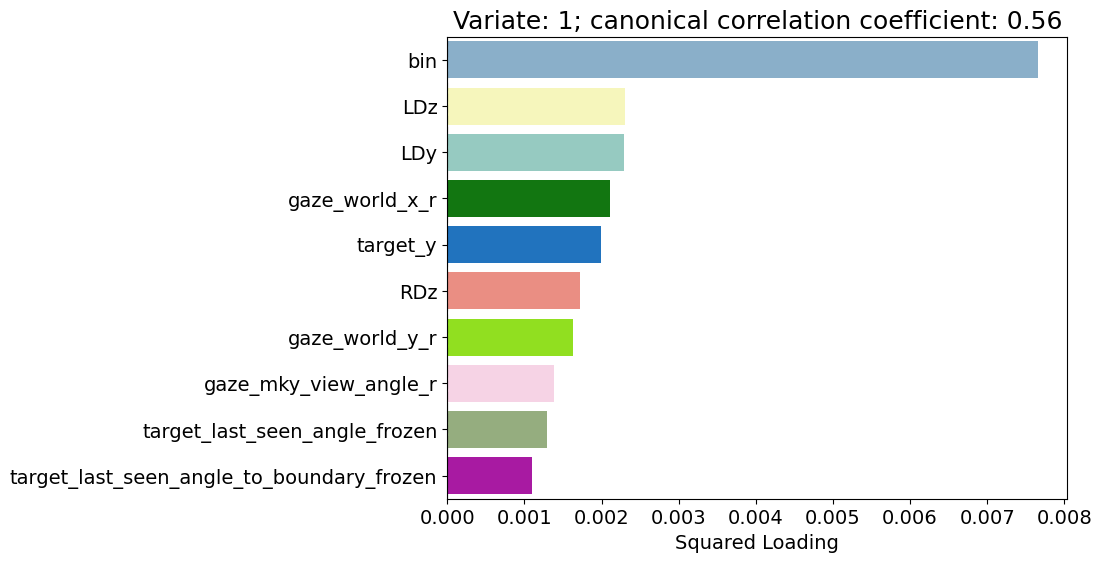

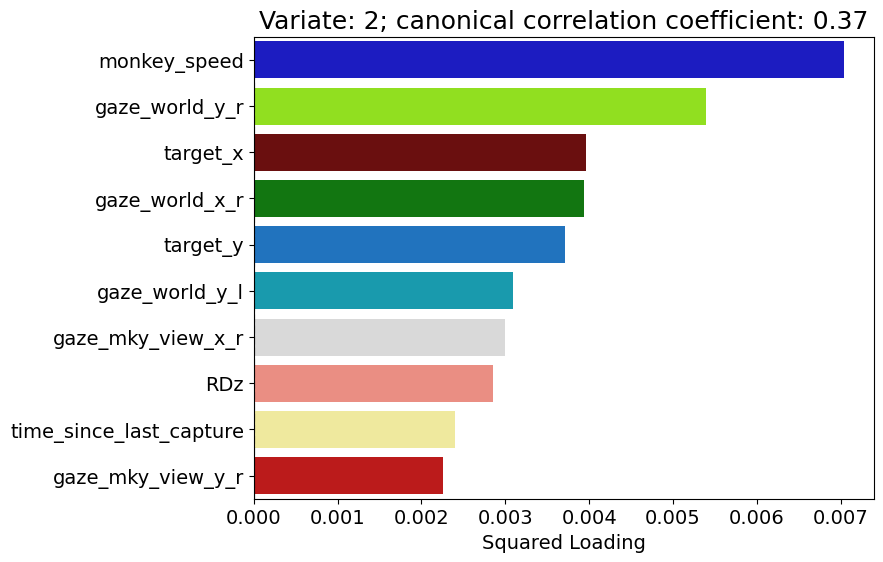

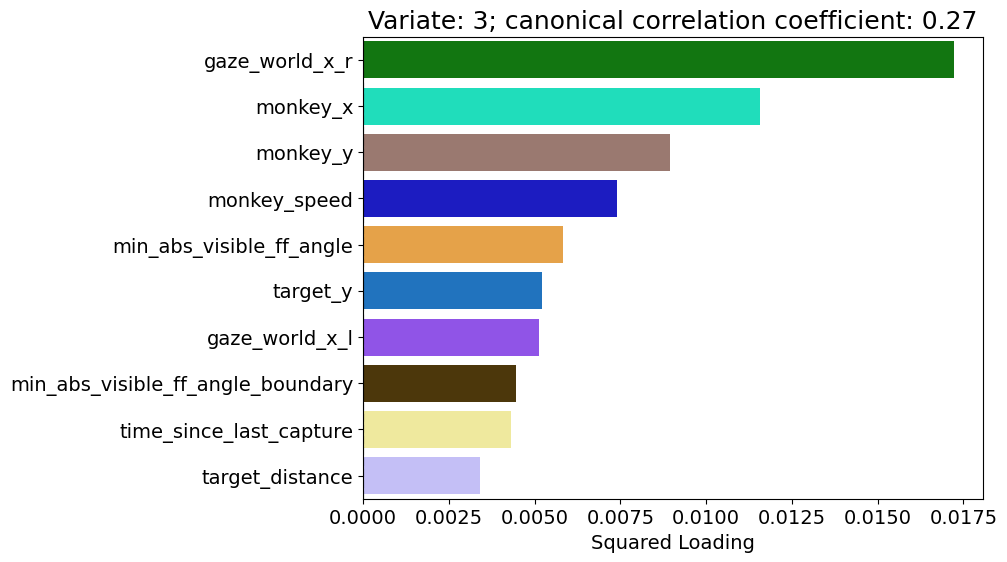

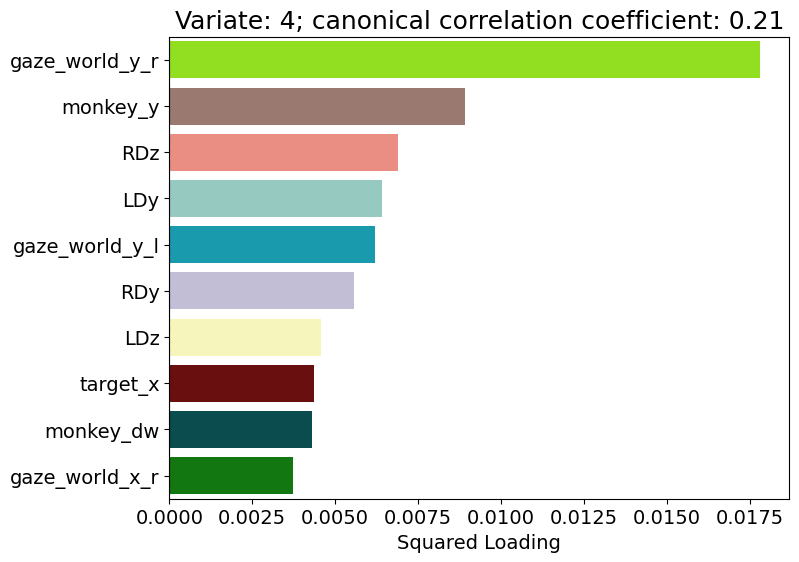

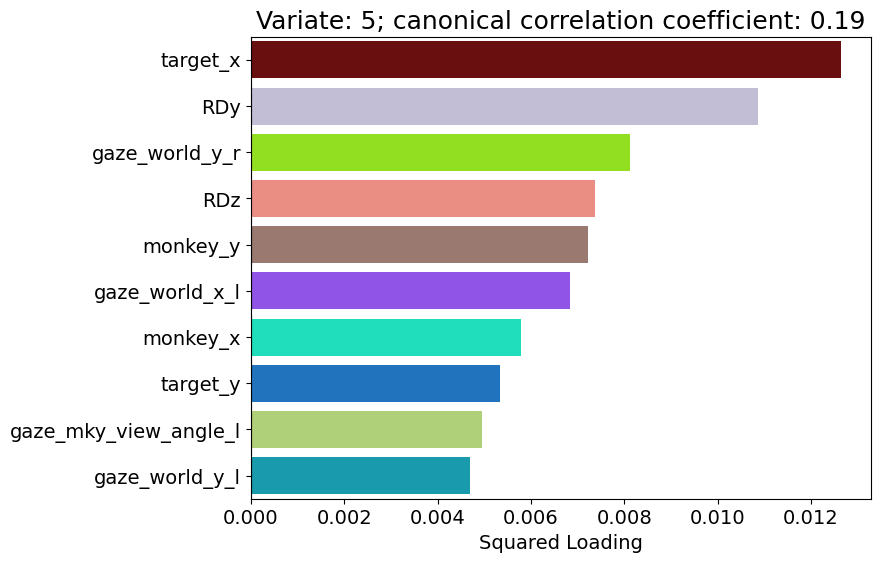

In [ ]:
cca_inst.plot_ranked_weights(X1_or_X2='X2', abs_value=False)

In [ ]:
stop here!

SyntaxError: invalid syntax (2745754519.py, line 1)

## distribution of each feature

In [ ]:
cca_inst.X2_sc.shape

(643, 13)

In [ ]:
X2_sc_df = pd.DataFrame(cca_inst.X2_sc, columns = cca_inst.X2.columns)
X2_sc_df.describe()

,nxt_ff_angle,nxt_ff_distance,alt_opt_arc_curv,time_rel_to_stop,traj_curv,cur_ff_angle,cur_ff_distance,cur_arc_curv,cur_opt_arc_curv,cur_opt_arc_dheading,bin,angle_from_m_before_stop_to_cur_ff,angle_from_m_before_stop_to_nxt_ff
count,643.00000,643.00000,643.00000,643.00000,643.00000,643.00000,643.00000,643.00000,643.00000,643.00000,643.00000,643.00000,643.00000
mean,0.00000,0.00000,0.00000,0.00000,0.00000,-0.00000,-0.00000,0.00000,-0.00000,0.00000,-0.00000,0.00000,0.00000
std,1.00078,1.00078,1.00078,1.00078,1.00078,1.00078,1.00078,1.00078,1.00078,1.00078,1.00078,1.00078,1.00078
min,-3.06447,-2.16544,-3.96562,-1.57732,-4.34350,-3.30498,-1.50602,-5.55899,-4.43541,-4.43994,-1.49796,-1.57970,-2.68969
25%,-0.59119,-0.70745,-0.55576,-0.83880,-0.54890,-0.49543,-0.89544,-0.24500,-0.41238,-0.21820,-0.92666,-0.91121,-0.50680
50%,-0.00339,-0.02846,0.02744,-0.07506,0.05584,0.02315,-0.09456,0.01361,0.03549,0.00683,-0.07230,-0.01794,0.00350
75%,0.55422,0.72042,0.59426,0.69499,0.57181,0.56417,0.78160,0.27760,0.42158,0.26639,0.91524,0.92376,0.66084
max,3.04556,2.89990,3.69564,3.08152,3.79653,3.51721,2.61942,6.79992,5.89334,4.41010,1.65778,1.72121,2.95743


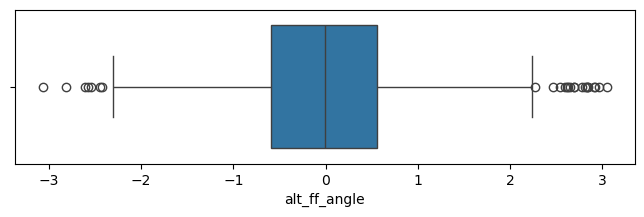

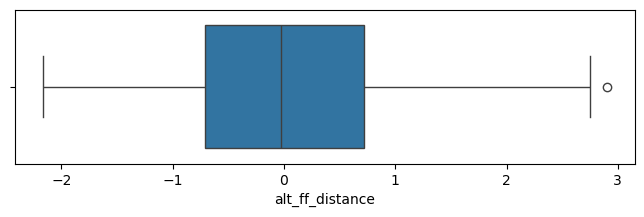

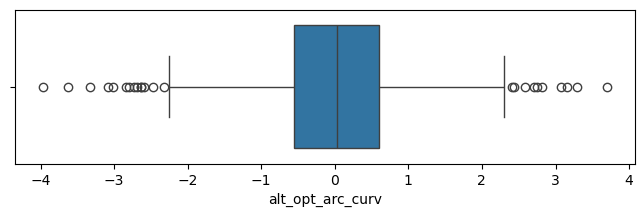

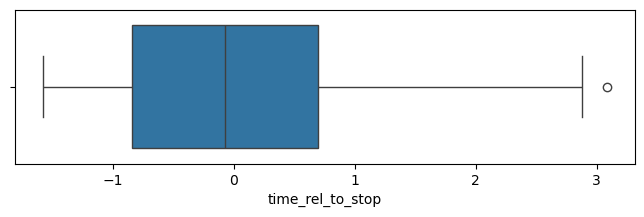

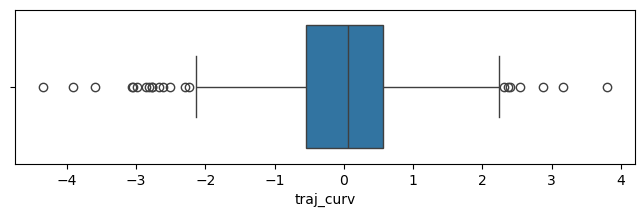

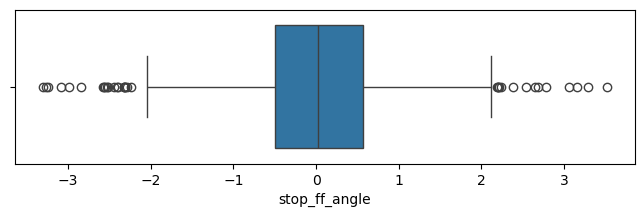

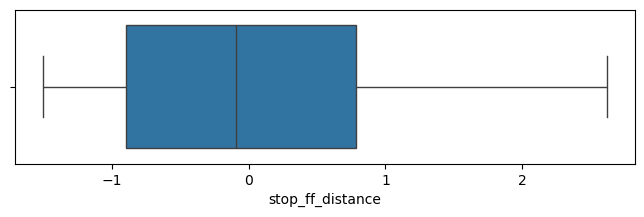

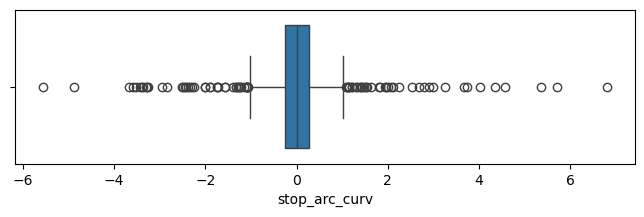

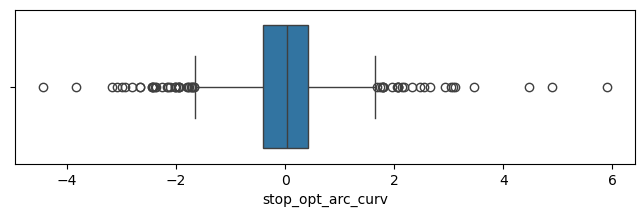

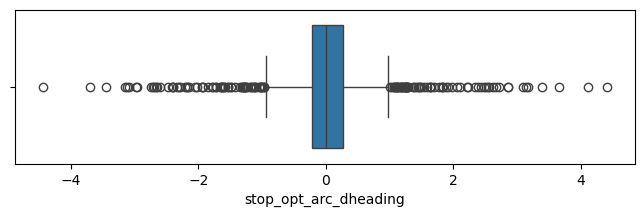

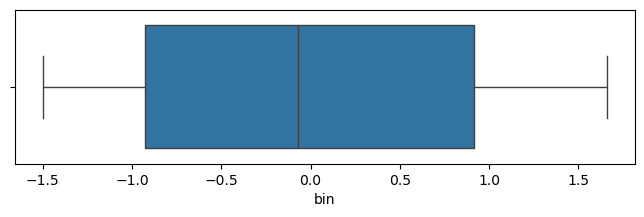

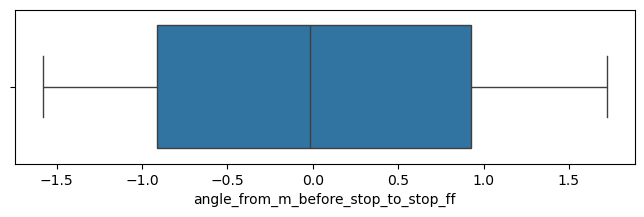

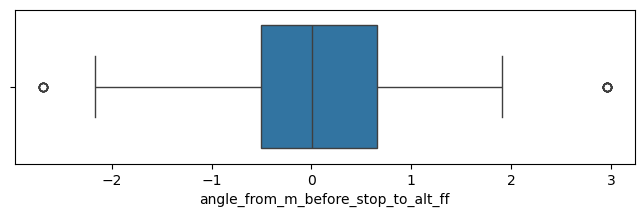

In [ ]:
for column in X2_sc_df.columns:
    plt.figure(figsize=(8, 2))
    sns.boxplot(X2_sc_df[column], orient='h')
    plt.show()
    

## heatmap of weights
raw canonical coefficients are interpreted in a manner analogous to interpreting regression coefficients. For example: a one unit increase in reading leads to a .0446 decrease in the first canonical variate of set 2 when all of the other variables are held constant (in some other data)

In [ ]:
weight_df = cca_inst.X2_weight_df.copy()
weight_df = weight_df.set_index('feature').drop(columns='feature_category')

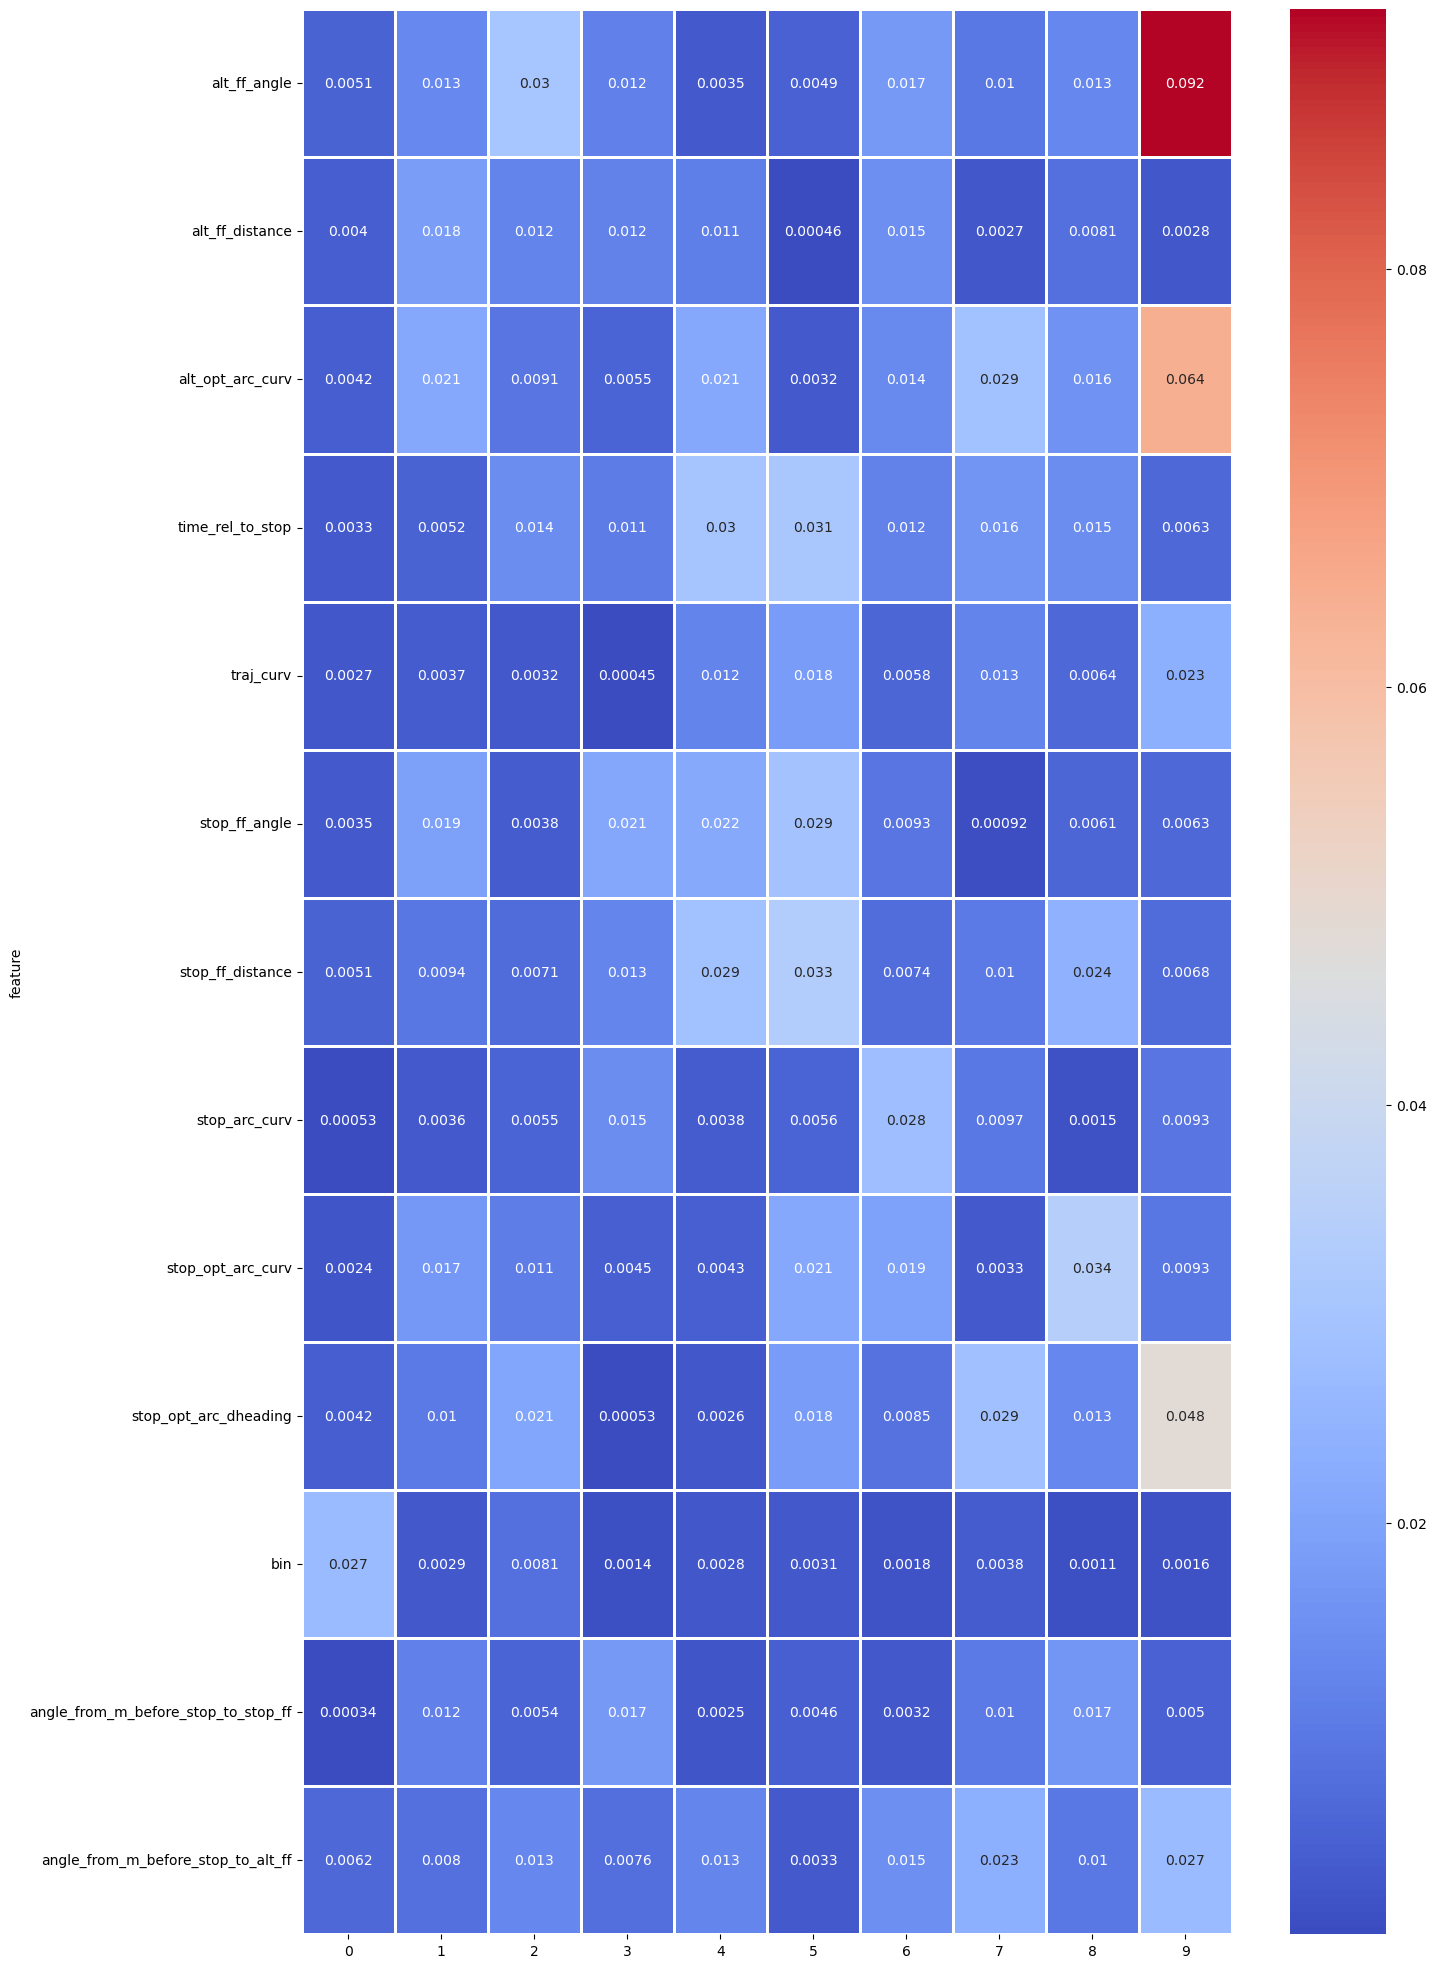

In [ ]:
plt.subplots(figsize=(15, 25))
sns.heatmap(weight_df.iloc[:20, :10], cmap='coolwarm', annot=True, linewidths=1)
plt.show()

## train test split

In [ ]:
train1, test1, train2, test2 = train_test_split(cca_inst.X1_sc, cca_inst.X2_sc, test_size=0.3, random_state=42)
# use training and testing set
nComponents = 10
cca2 = rcca.CCA(kernelcca = False, reg = 0., numCC = nComponents)
cca2.train([train1, train2])
testcorrs = cca2.validate([test1, test2])
testcorrs

Training CCA, kernel = None, regularization = 0.0000, 10 components


[array([ 0.16601,  0.27052, -0.04265,  0.21392,  0.07385,  0.04497,
         0.06918,  0.18854,  0.3288 , -0.04117,  0.10374,  0.41179,
         0.18181,  0.07008,  0.41278,  0.12765,  0.23815,  0.30137,
         0.13773,  0.32709,  0.40904,  0.42835,  0.36056,  0.16633,
         0.09906,  0.1593 ,  0.15809,  0.18762,  0.26092,  0.07841,
         0.1701 , -0.03962,  0.1092 ,  0.22486,  0.17081,  0.10919,
        -0.00575,  0.07872,  0.12964,  0.06004,  0.09885,  0.16676,
         0.24769,  0.14249,  0.45882,  0.14811,  0.45575, -0.00484,
         0.29337,  0.18232,  0.31452,  0.21348, -0.08977,  0.17961,
         0.06483,  0.07506,  0.1021 ,  0.19136,  0.23868,  0.1411 ,
         0.20266,  0.04708,  0.15282,  0.16654,  0.2962 ,  0.30952,
         0.12753,  0.07337,  0.09376,  0.14056,  0.04767,  0.37859,
         0.33603,  0.14019,  0.20891,  0.57302,  0.06753,  0.18801,
         0.09678,  0.038  ,  0.09279,  0.20425,  0.17003, -0.17356,
         0.14512,  0.11225]),
 array([ 0.72085, 

## compute explained variance

In [ ]:
cca2.compute_ev([test1, test2])

Computing explained variance for component #1
Computing explained variance for component #2
Computing explained variance for component #3
Computing explained variance for component #4
Computing explained variance for component #5
Computing explained variance for component #6
Computing explained variance for component #7
Computing explained variance for component #8
Computing explained variance for component #9
Computing explained variance for component #10


[array([[0.29637, 0.47038, 0.0378 , 0.36736, 0.14814, 0.26158, 0.0574 ,
         0.40039, 0.35631, 0.09605, 0.20393, 0.39169, 0.25049, 0.30972,
         0.40985, 0.1003 , 0.35105, 0.37228, 0.29432, 0.28156, 0.42894,
         0.09537, 0.45769, 0.31349, 0.26853, 0.32976, 0.38649, 0.34388,
         0.43198, 0.20538, 0.28921, 0.0131 , 0.25439, 0.25955, 0.11433,
         0.24517, 0.19142, 0.36757, 0.44289, 0.06147, 0.40519, 0.26793,
         0.26298, 0.26871, 0.50794, 0.06231, 0.54603, 0.16127, 0.35585,
         0.34024, 0.34508, 0.34122, 0.09512, 0.42817, 0.27054, 0.17302,
         0.37314, 0.34602, 0.41733, 0.27742, 0.22038, 0.29469, 0.22737,
         0.27435, 0.482  , 0.39625, 0.28468, 0.3218 , 0.28524, 0.16089,
         0.3863 , 0.44471, 0.31012, 0.13947, 0.17785, 0.52656, 0.23378,
         0.28259, 0.29749, 0.03473, 0.33107, 0.37959, 0.24742, 0.1145 ,
         0.19848, 0.13219],
        [0.16685, 0.19671, 0.13099, 0.25375, 0.08233, 0.07183, 0.1471 ,
         0.0396 , 0.06539, 0.27389, 

## test for p values

In [ ]:
stats_cca = CanCorr(cca_inst.X1_sc, cca_inst.X2_sc)
print(stats_cca.corr_test().summary())
neural_data_modeling.print_weights('X', stats_cca.x_cancoef)
neural_data_modeling.print_weights('Z', stats_cca.y_cancoef)

                              Cancorr results
   Canonical Correlation Wilks' lambda   Num DF     Den DF   F Value Pr > F
---------------------------------------------------------------------------
0                 0.8285        0.0208 3698.0000 547860.8057 15.6925 0.0000
1                 0.6838        0.0663 3570.0000 536405.3663 11.2254 0.0000
2                 0.6092        0.1245 3444.0000 524911.9670  8.8637 0.0000
3                 0.5047        0.1980 3320.0000 513379.2826  7.1067 0.0000
4                 0.4896        0.2656 3198.0000 501805.9337  6.0168 0.0000
5                 0.4324        0.3494 3078.0000 490190.4845  4.9415 0.0000
6                 0.4096        0.4297 2960.0000 478531.4418  4.1163 0.0000
7                 0.3536        0.5163 2844.0000 466827.2525  3.3447 0.0000
8                 0.3113        0.5901 2730.0000 455076.3024  2.7753 0.0000
9                 0.2571        0.6534 2618.0000 443276.9151  2.3315 0.0000
10                0.2159        0.6997 250

# PGAM (unfinished)

In [ ]:
## Categorize variables
dec.y_var.columns
temporal_vars = ['time_rel_to_stop',
 'time_when_nxt_ff_first_seen_rel_to_stop',
 'time_when_cur_ff_first_seen_rel_to_stop',
 'time_when_nxt_ff_last_seen_rel_to_stop',
 'time_when_cur_ff_last_seen_rel_to_stop',
 ]

spatial_vars = [x for x in dec.y_var.columns if x not in temporal_vars]
spatial_vars

# Appendix

## more columns (possibly get in the future)

get also get: (but to be honest, it doesn't make that much sense to get them....so let's skip for now.)
'distance traversed since target last visible',
'd angle since target last visible', 'target_at_right',
'time_till_capture', 'time from last visible to capture

Note that there might be multicollinearity. For example, duration from last visible to capture = time since target last visible + time till capture

Similarly, target angle = target angle last seen frozen - d angle since target last visible

(For distance it's not exactly the same because of the difference between distance and distance traversed, but it's still similar)

The multicollinearity is fine in linear regression (when each feature here is a y var), but need to be dealt with in cca.

## other thoughts

should i actually align each section, as if they are trials???
maybe i can try both that and continuous time... both can shed light on different behavioral variables
but for aligning trials, it may require alignment or warping since trial durations vary.

btw, what does it mean stitch data?

also, what does it look like to use RNN to model it?
I thought about the paper that Noah presented on


btw.......IME

## why ratio of bin/target_index approaches constant

In [ ]:
trial_lengths = dec.pursuit_data[['target_index', 'bin']].groupby('target_index').count()
trial_lengths.describe()

In [ ]:
sub = dec.y_var[['time', 'bin', 'target_index']]
sub['factor'] = dec.y_var['bin']/dec.y_var['target_index']
sub

In [ ]:
plt.hist(np.diff(dec.ff_caught_T_sorted), bins=30)
plt.xlabel('Time difference')
plt.ylabel('Count')
plt.title('Distribution of time differences between caught events')
plt.show()


In [ ]:
dec.ff_caught_T_sorted/np.arange(len(dec.ff_caught_T_sorted))